# Exploratory Data Analysis of the Voice Recognition Dataset

This notebook performs comprehensive EDA on the voice recognition dataset, including:
1. Initial EDA on full audio files (before segmentation)
2. Feature extraction and analysis
3. EDA on segmented audio and spectrograms

In [4]:
# Setup and Imports
import os
import librosa
import librosa.display
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import seaborn as sns
try:
    import parselmouth
    HAS_PARSELMOUTH = True
except ImportError:
    HAS_PARSELMOUTH = False
    print("Warning: parselmouth not installed. HNR features will be skipped.")
import scipy as sp
from pathlib import Path
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

# Set up paths
BASE_DIR = Path("..")
DATA_DIR = BASE_DIR / "data"
CUSTOM_DATASET_DIR = DATA_DIR / "custom_dataset"
METADATA_PATH = CUSTOM_DATASET_DIR / "metadata.csv"
AUDIO_DIR = CUSTOM_DATASET_DIR / "audio"
SPECTROGRAM_DIR = CUSTOM_DATASET_DIR / "spectrograms"
FULL_AUDIO_DIR = DATA_DIR / "full_audio_files"

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)


## 1. Initial EDA on Full Audio (Before Segmentation)

In [5]:
# Load metadata
metadata_df = pd.read_csv(METADATA_PATH) if METADATA_PATH.exists() else pd.DataFrame()
print(f"Metadata shape: {metadata_df.shape}")
if not metadata_df.empty:
    print(f"Metadata columns: {metadata_df.columns.tolist()}")
    print(f"Metadata head:\n{metadata_df.head()}")
else:
    print("Metadata file is empty or doesn't exist")


Metadata shape: (0, 0)
Metadata file is empty or doesn't exist


In [6]:
# Function to load full audio files
def load_full_audio_files(audio_dir, metadata_df=None, sr=16000):
    """
    Load full audio files from directory structure.
    Expected structure: audio_dir/accept/ and audio_dir/reject/ subdirectories
    """
    audio_data = []
    audio_extensions = {'.wav', '.mp3', '.flac', '.m4a', '.ogg'}
    
    if not audio_dir.exists():
        print(f"Audio directory not found: {audio_dir}")
        return audio_data
    
    # Check if metadata exists and has file_name column
    has_metadata = not metadata_df.empty and 'file_name' in metadata_df.columns
    
    # Try to find audio files in subdirectories (accept/reject structure)
    for subdir in audio_dir.iterdir():
        if subdir.is_dir():
            label = subdir.name  # accept or reject
            for audio_file in subdir.rglob('*'):
                if audio_file.suffix.lower() in audio_extensions:
                    try:
                        y, sample_rate = librosa.load(str(audio_file), sr=sr)
                        file_name = audio_file.name
                        
                        # Try to get metadata for this file
                        metadata_row = None
                        if has_metadata:
                            matching_rows = metadata_df[metadata_df['file_name'] == file_name]
                            if not matching_rows.empty:
                                metadata_row = matching_rows.iloc[0].to_dict()
                        
                        audio_data.append({
                            'file_path': str(audio_file),
                            'file_name': file_name,
                            'label': label,
                            'audio': y,
                            'sr': sample_rate,
                            'duration': len(y) / sample_rate,
                            'metadata': metadata_row
                        })
                        print(f"Loaded: {file_name} ({label}) - {len(y)/sample_rate:.2f}s")
                    except Exception as e:
                        print(f"Failed to load {audio_file}: {e}")
    
    # If no subdirectories found, try loading directly from audio_dir
    if not audio_data:
        for audio_file in audio_dir.rglob('*'):
            if audio_file.suffix.lower() in audio_extensions:
                try:
                    y, sample_rate = librosa.load(str(audio_file), sr=sr)
                    file_name = audio_file.name
                    
                    # Try to get label from metadata or filename
                    label = 'unknown'
                    metadata_row = None
                    if has_metadata:
                        matching_rows = metadata_df[metadata_df['file_name'] == file_name]
                        if not matching_rows.empty:
                            metadata_row = matching_rows.iloc[0].to_dict()
                            label = metadata_row.get('label', 'unknown')
                    
                    audio_data.append({
                        'file_path': str(audio_file),
                        'file_name': file_name,
                        'label': label,
                        'audio': y,
                        'sr': sample_rate,
                        'duration': len(y) / sample_rate,
                        'metadata': metadata_row
                    })
                    print(f"Loaded: {file_name} ({label}) - {len(y)/sample_rate:.2f}s")
                except Exception as e:
                    print(f"Failed to load {audio_file}: {e}")
    
    print(f"\n{'='*50}")
    print(f"Loaded {len(audio_data)} audio file(s)")
    print(f"{'='*50}")
    return audio_data

# Load full audio files
full_audio_data = load_full_audio_files(FULL_AUDIO_DIR, metadata_df)


Loaded: Artem_Poddierohin_1.wav (accept) - 338.05s
Loaded: DmitryHais2.wav (accept) - 300.48s
Loaded: DmitryHais3Reversed.wav (accept) - 199.91s
Loaded: Artem_Poddierohin_11Noised.wav (accept) - 272.96s
Loaded: Artem_Poddierohin_5Noised.wav (accept) - 34.86s
Loaded: DmitryHais3.wav (accept) - 199.91s
Loaded: Artem_Poddierohin_2.wav (accept) - 52.37s
Loaded: ValentynReversed.wav (accept) - 191.34s
Loaded: DmitryHais1.wav (accept) - 355.60s
Loaded: Artem_Poddierohin_9Reversed.wav (accept) - 101.27s
Loaded: Artem_Poddierohin_8Noised.wav (accept) - 149.40s
Loaded: Artem_Poddierohin_3.wav (accept) - 109.10s
Loaded: Artem_Poddierohin_7.wav (accept) - 100.10s
Loaded: Artem_Poddierohin_3Noised.wav (accept) - 109.10s
Loaded: DmitryHais1Noised.wav (accept) - 355.60s
Loaded: Artem_Poddierohin_6.wav (accept) - 172.25s
Loaded: Artem_Poddierohin_4.wav (accept) - 161.22s
Loaded: Artem_Poddierohin_5Reversed.wav (accept) - 34.86s
Loaded: Valentyn3Reversed.wav (accept) - 667.84s
Loaded: Artem_Poddierohi

In [7]:
# Create summary DataFrame for full audio
if full_audio_data:
    full_audio_summary = []
    for item in full_audio_data:
        summary = {
            'file_name': item['file_name'],
            'label': item['label'],
            'duration': item['duration'],
            'file_path': item['file_path']
        }
        # Add metadata if available (only place, since gender/age/duration_s were removed)
        if item['metadata']:
            if 'place' in item['metadata']:
                summary['place'] = item['metadata']['place']
        full_audio_summary.append(summary)
    
    full_audio_df = pd.DataFrame(full_audio_summary)
    print("Full Audio Summary:")
    print(full_audio_df.head())
    print(f"\nShape: {full_audio_df.shape}")
else:
    print("No full audio files found. Please ensure audio files are in data/full_audio_files/")
    full_audio_df = pd.DataFrame()


Full Audio Summary:
                        file_name   label    duration  \
0         Artem_Poddierohin_1.wav  accept  338.048000   
1                 DmitryHais2.wav  accept  300.478687   
2         DmitryHais3Reversed.wav  accept  199.914688   
3  Artem_Poddierohin_11Noised.wav  accept  272.960000   
4   Artem_Poddierohin_5Noised.wav  accept   34.858688   

                                           file_path  
0  ../data/full_audio_files/accept/Artem_Poddiero...  
1    ../data/full_audio_files/accept/DmitryHais2.wav  
2  ../data/full_audio_files/accept/DmitryHais3Rev...  
3  ../data/full_audio_files/accept/Artem_Poddiero...  
4  ../data/full_audio_files/accept/Artem_Poddiero...  

Shape: (1554, 4)


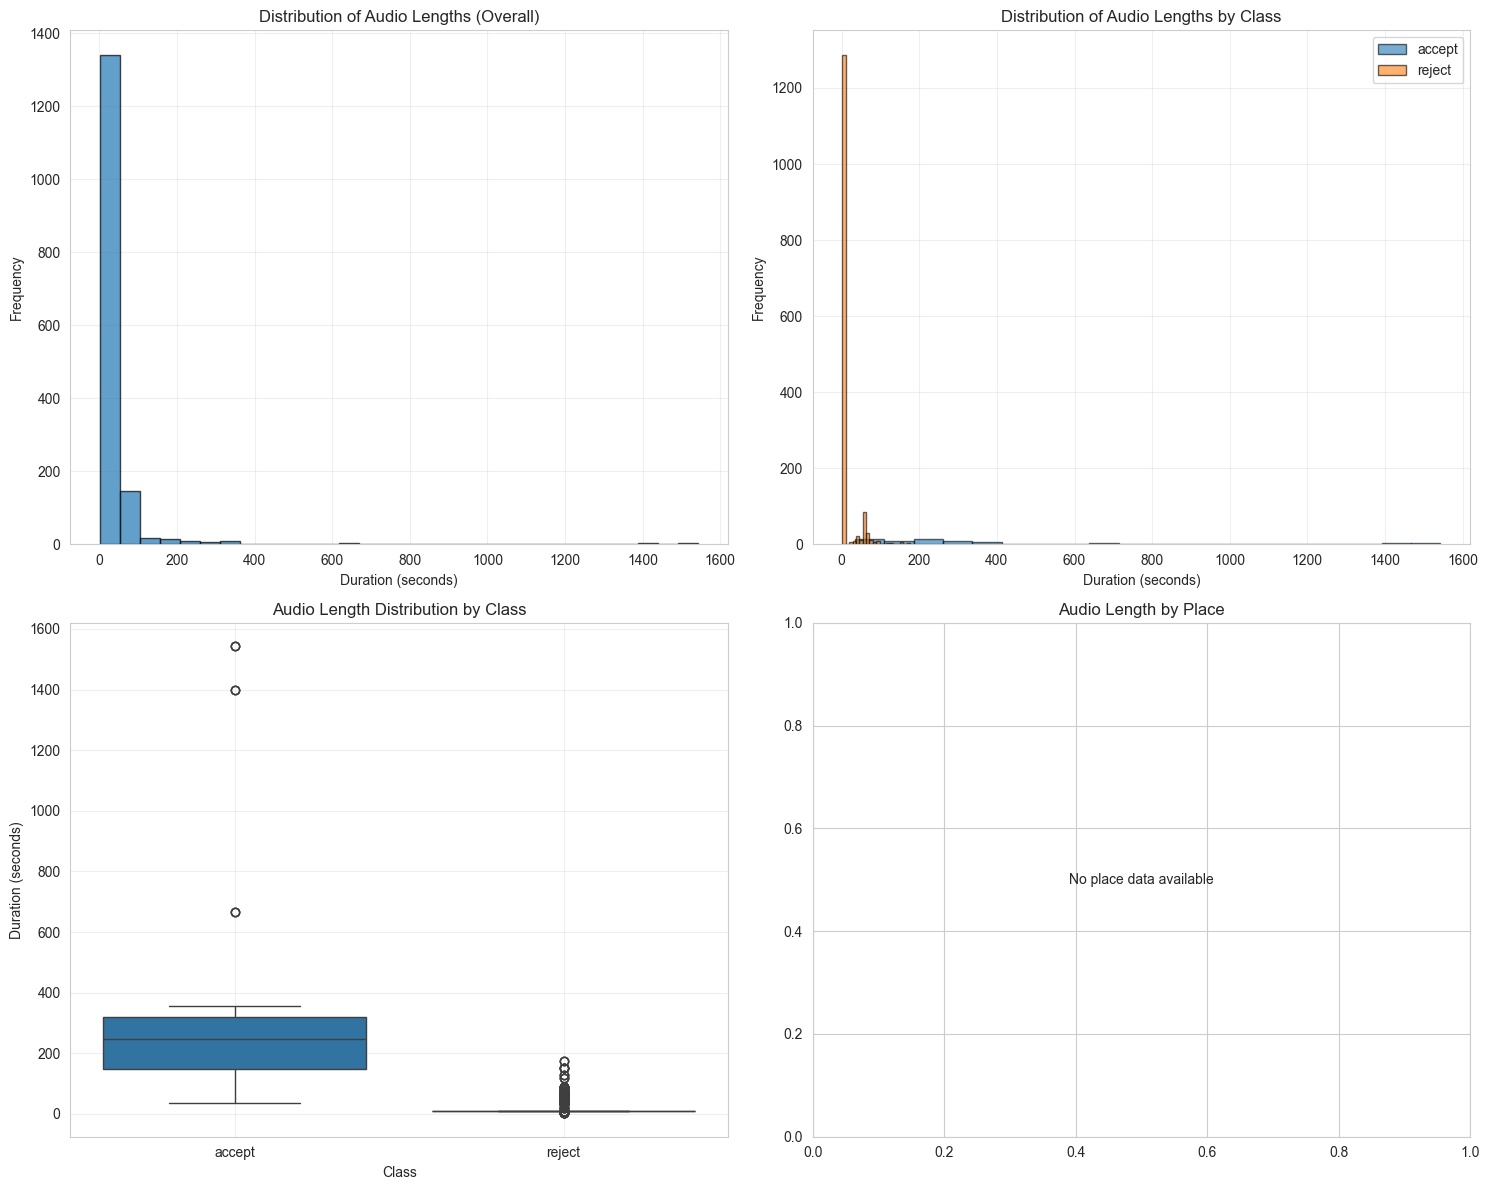

In [8]:
# Visualize audio length distributions
if not full_audio_df.empty:
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # Overall histogram
    axes[0, 0].hist(full_audio_df['duration'], bins=30, edgecolor='black', alpha=0.7)
    axes[0, 0].set_title('Distribution of Audio Lengths (Overall)')
    axes[0, 0].set_xlabel('Duration (seconds)')
    axes[0, 0].set_ylabel('Frequency')
    axes[0, 0].grid(True, alpha=0.3)
    
    # Histogram by class
    if len(full_audio_df['label'].unique()) > 1:
        for label in full_audio_df['label'].unique():
            label_data = full_audio_df[full_audio_df['label'] == label]['duration']
            axes[0, 1].hist(label_data, bins=20, alpha=0.6, label=label, edgecolor='black')
        axes[0, 1].set_title('Distribution of Audio Lengths by Class')
        axes[0, 1].set_xlabel('Duration (seconds)')
        axes[0, 1].set_ylabel('Frequency')
        axes[0, 1].legend()
        axes[0, 1].grid(True, alpha=0.3)
    
    # Box plot by class
    if len(full_audio_df['label'].unique()) > 1:
        sns.boxplot(data=full_audio_df, x='label', y='duration', ax=axes[1, 0])
        axes[1, 0].set_title('Audio Length Distribution by Class')
        axes[1, 0].set_xlabel('Class')
        axes[1, 0].set_ylabel('Duration (seconds)')
        axes[1, 0].grid(True, alpha=0.3)
    
    # Box plot by place if available
    if 'place' in full_audio_df.columns:
        place_data = full_audio_df[full_audio_df['place'].notna() & (full_audio_df['place'] != 'unknown')]
        if len(place_data) > 0 and len(place_data['place'].unique()) > 1:
            # Limit to top 10 places for readability
            top_places = place_data['place'].value_counts().head(10).index
            plot_df = place_data[place_data['place'].isin(top_places)]
            sns.boxplot(data=plot_df, x='place', y='duration', ax=axes[1, 1])
            axes[1, 1].set_title('Audio Length Distribution by Place (Top 10)')
            axes[1, 1].set_xlabel('Place')
            axes[1, 1].set_ylabel('Duration (seconds)')
            axes[1, 1].tick_params(axis='x', rotation=45)
            axes[1, 1].grid(True, alpha=0.3)
        else:
            axes[1, 1].text(0.5, 0.5, 'No place data available', 
                           ha='center', va='center', transform=axes[1, 1].transAxes)
            axes[1, 1].set_title('Audio Length by Place')
    else:
        axes[1, 1].text(0.5, 0.5, 'No place data available', 
                       ha='center', va='center', transform=axes[1, 1].transAxes)
        axes[1, 1].set_title('Audio Length by Place')
    
    plt.tight_layout()
    plt.show()
else:
    print("No data to visualize")


### 1. Overall Distribution (Top-Left Histogram)
The histogram shows a **highly right-skewed distribution** of audio durations across the entire dataset. The vast majority of audio files (over 1,300) are concentrated in the shortest duration bin (0-50 seconds), indicating that most recordings in the dataset are relatively short. The frequency drops dramatically for longer durations, with very few files exceeding 200 seconds. A small number of extreme outliers extend up to approximately 1,500 seconds.

**Key Insight**: The dataset is dominated by short audio recordings, with a few exceptionally long files creating a long tail in the distribution.


### 3. Box Plot by Class (Bottom-Left)
The box plots reveal distinct distribution characteristics for each class:

**Accept Class**:
- **Median**: Approximately 200 seconds
- **Interquartile Range (IQR)**: Roughly 100-300 seconds
- **Outliers**: Several outliers exist, including values around 650, 1,400, and 1,550 seconds
- The distribution shows moderate variability with a tendency toward longer durations

**Reject Class**:
- **Median**: Near 0 seconds (extremely short)
- **IQR**: Very narrow, indicating minimal variation
- **Outliers**: Numerous outliers densely packed between 0-250 seconds, but all relatively short compared to "accept" outliers
- The distribution is highly compressed, suggesting that "reject" recordings are consistently very brief

**Key Insight**: There is a fundamental difference in duration characteristics between classes - "accept" recordings are generally longer with more variability, while "reject" recordings are uniformly short.

### Summary and Recommendations

1. **Class Imbalance**: The dataset shows severe class imbalance, with "accept" class having approximately 8-10 times more recordings than "reject" class. This should be addressed through:
   - Data augmentation for the "reject" class
   - Class weighting in model training
   - Stratified sampling techniques

2. **Duration Differences**: The significant difference in duration distributions between classes may impact model performance. Consider:
   - Normalizing or segmenting all audio to consistent lengths
   - Using duration as a feature in classification
   - Separate handling of extremely long "accept" outliers

In [9]:
# Identify extremely short or extremely noisy recordings
if not full_audio_df.empty and len(full_audio_df) > 0:
    print("="*60)
    print("OUTLIER DETECTION")
    print("="*60)
    
    # Extremely short recordings (below 1st percentile or less than 1 second)
    duration_threshold_short = max(full_audio_df['duration'].quantile(0.01), 1.0)
    short_recordings = full_audio_df[full_audio_df['duration'] < duration_threshold_short]
    
    print(f"\n1. Extremely short recordings (< {duration_threshold_short:.2f} seconds):")
    print(f"   Found {len(short_recordings)} recordings")
    if len(short_recordings) > 0:
        print(short_recordings[['file_name', 'label', 'duration']].to_string(index=False))
    
    # Extremely long recordings (above 99th percentile)
    duration_threshold_long = full_audio_df['duration'].quantile(0.99)
    long_recordings = full_audio_df[full_audio_df['duration'] > duration_threshold_long]
    
    print(f"\n2. Extremely long recordings (> {duration_threshold_long:.2f} seconds):")
    print(f"   Found {len(long_recordings)} recordings")
    if len(long_recordings) > 0:
        print(long_recordings[['file_name', 'label', 'duration']].to_string(index=False))
    
    # Detect noisy recordings using ZCR and spectral analysis
    print("\n3. Analyzing noise levels...")
    noisy_recordings = []
    
    for idx, item in enumerate(full_audio_data):
        y = item['audio']
        sr = item['sr']
        
        # Zero Crossing Rate (high ZCR can indicate noise)
        zcr = np.mean(librosa.feature.zero_crossing_rate(y)[0])
        
        # Spectral centroid (noisy signals often have different spectral characteristics)
        spectral_centroid = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr))
        
        # RMS energy
        rms = np.mean(librosa.feature.rms(y=y)[0])
        
        # Store metrics
        item['zcr'] = zcr
        item['spectral_centroid'] = spectral_centroid
        item['rms'] = rms
    
    # Calculate thresholds for noise detection
    zcr_values = [item['zcr'] for item in full_audio_data]
    zcr_threshold_high = np.percentile(zcr_values, 95)
    
    rms_values = [item['rms'] for item in full_audio_data]
    rms_threshold_low = np.percentile(rms_values, 5)
    
    # Identify potentially noisy recordings
    for item in full_audio_data:
        if item['zcr'] > zcr_threshold_high or item['rms'] < rms_threshold_low:
            noisy_recordings.append({
                'file_name': item['file_name'],
                'label': item['label'],
                'zcr': item['zcr'],
                'rms': item['rms'],
                'spectral_centroid': item['spectral_centroid']
            })
    
    print(f"   Found {len(noisy_recordings)} potentially noisy recordings")
    if len(noisy_recordings) > 0:
        noisy_df = pd.DataFrame(noisy_recordings)
        print(noisy_df.to_string(index=False))
else:
    print("No data for outlier detection")


OUTLIER DETECTION

1. Extremely short recordings (< 5.00 seconds):
   Found 9 recordings
                          file_name  label  duration
                    TheEgg_0076.wav reject  2.040812
     DoorIntheWall_0254Reversed.wav reject  2.027750
              TheEgg_0076Noised.wav reject  2.040812
ObamaSpeech2004DNC_0096Reversed.wav reject  4.597563
  ObamaSpeech2004DNC_0096Noised.wav reject  4.597563
        ObamaSpeech2004DNC_0096.wav reject  4.597563
            TheEgg_0076Reversed.wav reject  2.040812
       DoorIntheWall_0254Noised.wav reject  2.027750
             DoorIntheWall_0254.wav reject  2.027750

2. Extremely long recordings (> 320.62 seconds):
   Found 15 recordings
                      file_name  label  duration
        Artem_Poddierohin_1.wav accept   338.048
                DmitryHais1.wav accept   355.604
          DmitryHais1Noised.wav accept   355.604
          Valentyn3Reversed.wav accept   667.840
             egecanReversed.wav accept  1399.060
              

## 2. Feature Extraction and Analysis


In [10]:
# Feature extraction function adapted from example
def extract_features(y, label=None, place=None, sr=16000, n_mfcc=13):
    """
    Extract comprehensive audio features from audio signal.
    """
    features = {}
    
    # Metadata
    if label is not None:
        features["label"] = label
    if place is not None:
        features["place"] = place
    
    ## Basic features
    features["y_mean"] = np.nanmean(y)
    features["y_std"] = np.nanstd(y)
    features["y_iqr"] = np.subtract(*np.percentile(y, [75, 25]))
    features["y_skew"] = sp.stats.skew(y)
    features["y_kurt"] = sp.stats.kurtosis(y)
    
    ## Temporal features
    # Root Mean Square energy
    features["rms"] = np.mean(librosa.feature.rms(y=y))
    
    # Zero Crossing Rate
    features["zcr"] = np.mean(librosa.feature.zero_crossing_rate(y))
    
    ## Spectral features
    # Mel-frequency cepstral coefficients
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    for i in range(n_mfcc):
        features[f"mfcc_{i+1}"] = np.mean(mfcc[i])
    
    # Spectral centroid
    features["spectral_centroid"] = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr))
    
    # Spectral bandwidth
    features["spectral_bandwidth"] = np.mean(librosa.feature.spectral_bandwidth(y=y, sr=sr))
    
    # Rolloff
    features["rolloff"] = np.mean(librosa.feature.spectral_rolloff(y=y, sr=sr))
    
    # Spectral contrast
    spectral_contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
    for i in range(spectral_contrast.shape[0]):
        features[f"spectral_contrast_{i+1}"] = np.mean(spectral_contrast[i])
    
    ## Harmonic features
    # F0 / Pitch
    try:
        f0, _, _ = librosa.pyin(y, fmin=50, fmax=300)
        features["f0_mean"] = np.nanmean(f0)
        features["f0_std"] = np.nanstd(f0)
    except:
        features["f0_mean"] = np.nan
        features["f0_std"] = np.nan
    
    # Harmonic-to-Noise-Ratio (HNR)
    if HAS_PARSELMOUTH:
        try:
            snd = parselmouth.Sound(y, sampling_frequency=sr)
            harmonicity = snd.to_harmonicity()
            hnr = harmonicity.values
            features["hnr"] = np.nanmean(hnr)
        except:
            features["hnr"] = np.nan
    else:
        features["hnr"] = np.nan
    
    return features

def process_audio(item):
    """Process audio item and extract features."""
    y = item['audio']
    sr = item['sr']
    label = item.get('label', None)
    
    # Get metadata
    metadata = item.get('metadata', {})
    place = metadata.get('place', None) if metadata else None
    
    print(f"Extracting features for: {item['file_name']}")
    return extract_features(y=y, sr=sr, label=label, place=place)


In [11]:
# Extract features from full audio files
if full_audio_data:
    print("Extracting features from full audio files...")
    features_list = []
    
    for item in full_audio_data:
        try:
            features = process_audio(item)
            features_list.append(features)
        except Exception as e:
            print(f"Error processing {item['file_name']}: {e}")
    
    features_df = pd.DataFrame(features_list)
    print(f"\n{'='*50}")
    print(f"Feature extraction complete!")
    print(f"Features DataFrame shape: {features_df.shape}")
    print(f"{'='*50}")
    print(f"\nColumns: {features_df.columns.tolist()}")
else:
    print("No audio data available for feature extraction")
    features_df = pd.DataFrame()


Extracting features from full audio files...
Extracting features for: Artem_Poddierohin_1.wav
Extracting features for: DmitryHais2.wav
Extracting features for: DmitryHais3Reversed.wav
Extracting features for: Artem_Poddierohin_11Noised.wav
Extracting features for: Artem_Poddierohin_5Noised.wav
Extracting features for: DmitryHais3.wav
Extracting features for: Artem_Poddierohin_2.wav
Extracting features for: ValentynReversed.wav
Extracting features for: DmitryHais1.wav
Extracting features for: Artem_Poddierohin_9Reversed.wav
Extracting features for: Artem_Poddierohin_8Noised.wav
Extracting features for: Artem_Poddierohin_3.wav
Extracting features for: Artem_Poddierohin_7.wav
Extracting features for: Artem_Poddierohin_3Noised.wav
Extracting features for: DmitryHais1Noised.wav
Extracting features for: Artem_Poddierohin_6.wav
Extracting features for: Artem_Poddierohin_4.wav
Extracting features for: Artem_Poddierohin_5Reversed.wav
Extracting features for: Valentyn3Reversed.wav
Extracting fea

### Clustering Analysis


Clustering complete: 2 clusters


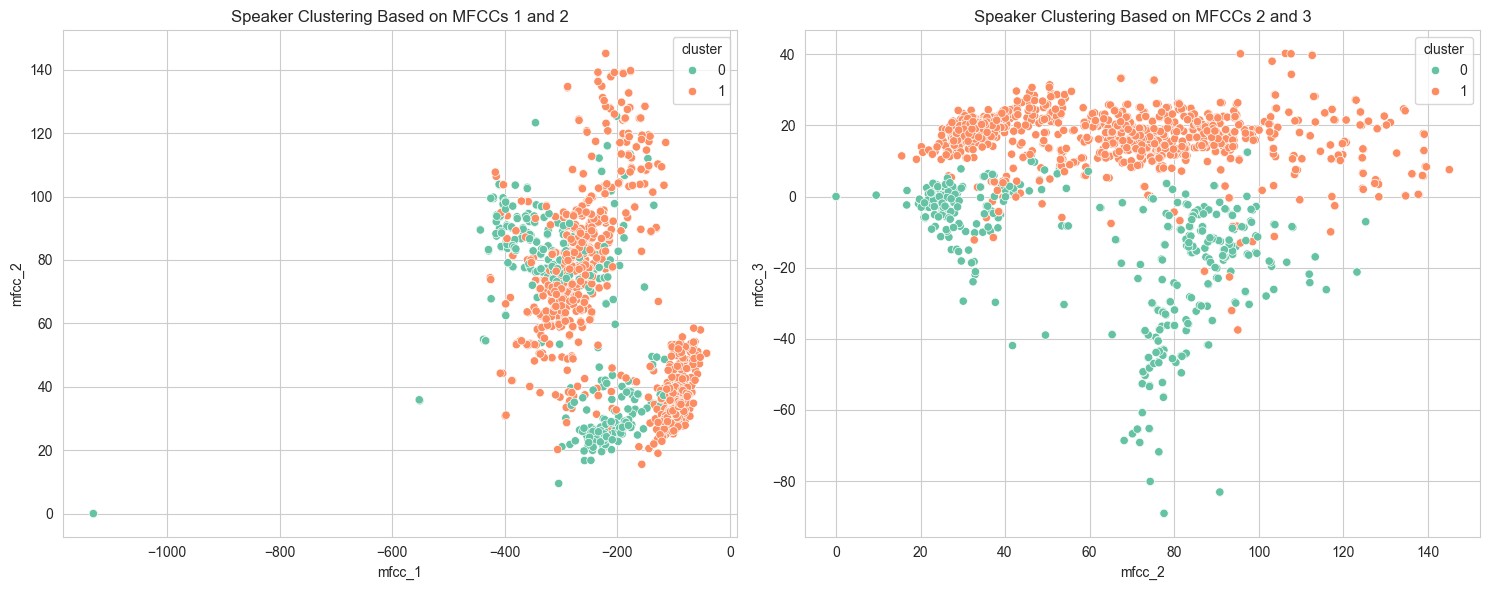


Cluster vs Label comparison:
label    accept  reject
cluster                
0            40     409
1            23    1082


In [ ]:
# K-Means clustering on MFCC features
if not features_df.empty:
    # Select MFCC features
    n_mfcc = 13
    mfcc_cols = [f"mfcc_{i+1}" for i in range(n_mfcc)]
    available_mfcc_cols = [col for col in mfcc_cols if col in features_df.columns]
    
    if len(available_mfcc_cols) > 0:
        mfcc_features = features_df[available_mfcc_cols].dropna()
        
        if len(mfcc_features) > 1:
            # Standardize features
            scaler = StandardScaler()
            mfcc_scaled = scaler.fit_transform(mfcc_features)
            
            # Determine number of clusters (use number of labels if available, else 2)
            n_clusters = 2
            if 'label' in features_df.columns:
                n_clusters = min(len(features_df['label'].unique()), len(mfcc_features))
            
            # K-Means clustering
            kmeans = KMeans(n_clusters=n_clusters, random_state=19, n_init=10)
            cluster_labels = kmeans.fit_predict(mfcc_scaled)
            
            # Add cluster labels to dataframe
            features_df_clustered = features_df.loc[mfcc_features.index].copy()
            features_df_clustered["cluster"] = cluster_labels
            
            print(f"Clustering complete: {n_clusters} clusters")
            
            # Visualize clusters
            fig, axes = plt.subplots(1, 2, figsize=(15, 6))
            
            # Cluster by MFCC 1 and 2
            if 'mfcc_1' in features_df_clustered.columns and 'mfcc_2' in features_df_clustered.columns:
                sns.scatterplot(
                    x=features_df_clustered["mfcc_1"], 
                    y=features_df_clustered["mfcc_2"], 
                    hue=features_df_clustered["cluster"], 
                    palette="Set2",
                    ax=axes[0]
                )
                axes[0].set_title("Speaker Clustering Based on MFCCs 1 and 2")
            
            # Cluster by MFCC 2 and 3
            if 'mfcc_2' in features_df_clustered.columns and 'mfcc_3' in features_df_clustered.columns:
                sns.scatterplot(
                    x=features_df_clustered["mfcc_2"], 
                    y=features_df_clustered["mfcc_3"], 
                    hue=features_df_clustered["cluster"], 
                    palette="Set2",
                    ax=axes[1]
                )
                axes[1].set_title("Speaker Clustering Based on MFCCs 2 and 3")
            
            plt.tight_layout()
            plt.show()
            
            # Compare clusters with actual labels if available
            if 'label' in features_df_clustered.columns:
                print("\nCluster vs Label comparison:")
                print(pd.crosstab(features_df_clustered['cluster'], features_df_clustered['label']))
        else:
            print("Not enough valid MFCC data for clustering")
    else:
        print("MFCC features not available for clustering")
else:
    print("No features available for clustering")


### Results: Speaker Clustering Based on MFCCs

These scatter plots visualize K-means clustering results applied to Mel-frequency cepstral coefficients (MFCCs). MFCCs capture vocal timbre and are commonly used for speaker identification. The plots show how two clusters (Cluster 0 in teal, Cluster 1 in coral) are distributed across different MFCC feature pairs.

### 1. Clustering with MFCCs 1 and 2 (Left Plot)

- **Cluster 0 (teal)**: Concentrated in the region where `mfcc_1` ranges from -500 to -200 and `mfcc_2` ranges from 20 to 120, with highest density around `mfcc_1` = -300 to -250 and `mfcc_2` = 60 to 100. One outlier at `mfcc_1` ≈ -1100.
- **Cluster 1 (coral)**: More broadly distributed with significant overlap with Cluster 0 in the central region. Has distinct dense groups:
  - Bottom-right: `mfcc_1` = -300 to 0, `mfcc_2` = 20 to 60
  - Top-right: `mfcc_1` = -200 to 0, `mfcc_2` = 100 to 140

**Interpretation**: Considerable overlap between clusters when using only MFCCs 1 and 2. These two features alone provide limited discriminative power for separating these speaker groups.

### 2. Clustering with MFCCs 2 and 3 (Right Plot)

- **Cluster 0 (teal)**: Predominantly in the lower-left region:
  - `mfcc_2`: 0 to 100
  - `mfcc_3`: -80 to 10
  - Dense core around `mfcc_2` = 40-80, `mfcc_3` = -20 to 0
- **Cluster 1 (coral)**: Primarily in the upper-right region:
  - `mfcc_2`: 20 to 150
  - `mfcc_3`: 0 to 40
  - Dense core around `mfcc_2` = 60-120, `mfcc_3` = 10 to 30

**Interpretation**: Much clearer separation between clusters. Cluster 1 generally has higher `mfcc_3` values, while Cluster 0 has lower `mfcc_3` values for similar `mfcc_2` ranges. The combination of MFCCs 2 and 3 is more effective for distinguishing between these speaker groups.

### Key Insights

1. **Feature selection matters**: Different MFCC pairs have varying discriminative power. MFCCs 2 and 3 provide better separation than MFCCs 1 and 2.
2. **Cluster characteristics**: 
   - Cluster 0: Lower `mfcc_3` values (possibly indicating different vocal characteristics)
   - Cluster 1: Higher `mfcc_3` values with more spread
3. **Practical implications**: For speaker classification or verification tasks, focusing on MFCCs 2 and 3 (or higher-order MFCCs) may yield better results than using only the first two coefficients.
4. **Limitations**: With only 2 clusters, this analysis captures broad speaker groups. More clusters or additional features may reveal finer-grained speaker distinctions.

### Spectral Analysis


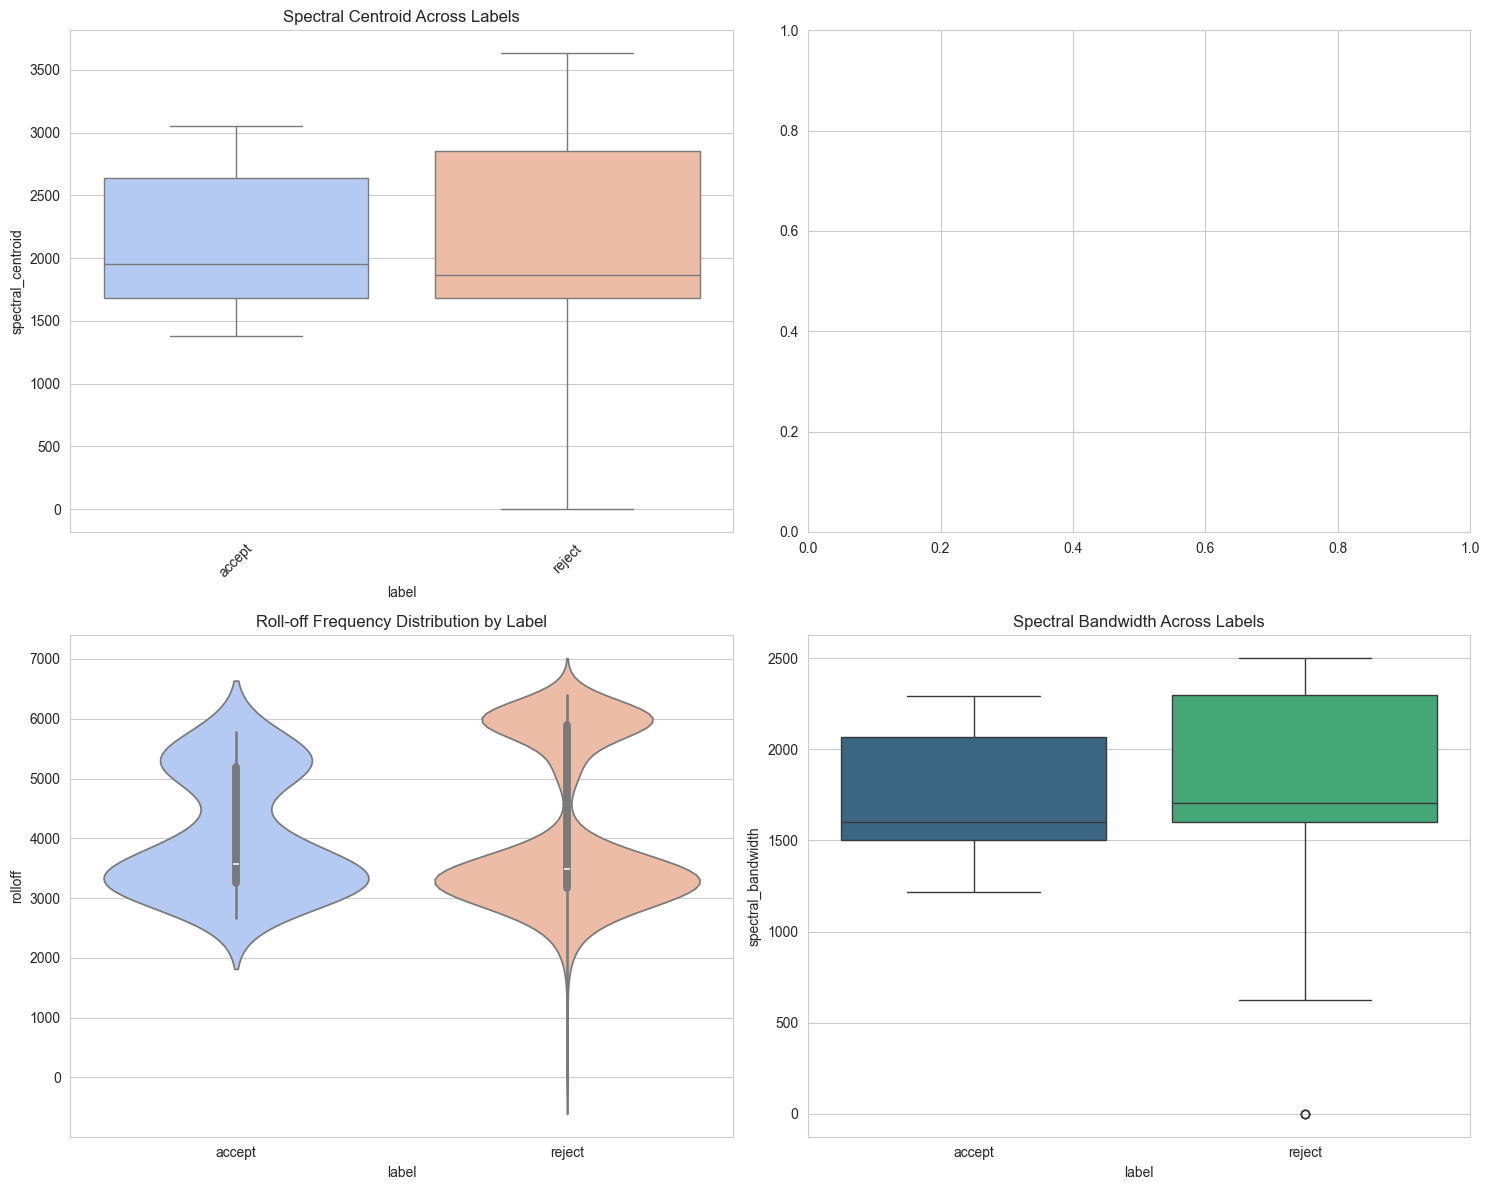

In [15]:
# Spectral feature analysis
if not features_df.empty:
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # Spectral centroid by label
    if 'label' in features_df.columns and 'spectral_centroid' in features_df.columns:
        if len(features_df['label'].unique()) > 1:
            sns.boxplot(x="label", y="spectral_centroid", data=features_df, palette="coolwarm", ax=axes[0, 0])
            axes[0, 0].set_title("Spectral Centroid Across Labels")
            axes[0, 0].tick_params(axis='x', rotation=45)
    
    # Spectral centroid by place
    if 'place' in features_df.columns and 'spectral_centroid' in features_df.columns:
        place_data = features_df[features_df['place'].notna()]
        if len(place_data) > 0 and len(place_data['place'].unique()) > 1:
            sns.boxplot(x="place", y="spectral_centroid", data=place_data, palette="coolwarm", ax=axes[0, 1])
            axes[0, 1].set_title("Spectral Centroid Across Places")
            axes[0, 1].tick_params(axis='x', rotation=45)
    
    # Rolloff by label
    if 'label' in features_df.columns and 'rolloff' in features_df.columns:
        if len(features_df['label'].unique()) > 1:
            sns.violinplot(x="label", y="rolloff", data=features_df, palette="coolwarm", ax=axes[1, 0])
            axes[1, 0].set_title("Roll-off Frequency Distribution by Label")
    
    # Spectral bandwidth by label
    if 'label' in features_df.columns and 'spectral_bandwidth' in features_df.columns:
        if len(features_df['label'].unique()) > 1:
            sns.boxplot(x="label", y="spectral_bandwidth", data=features_df, palette="viridis", ax=axes[1, 1])
            axes[1, 1].set_title("Spectral Bandwidth Across Labels")
    
    plt.tight_layout()
    plt.show()
else:
    print("No features available for spectral analysis")


### Results: Spectral Analysis (Accept vs Reject)

These plots compare spectral characteristics between "accept" and "reject" audio files. Spectral features capture frequency-domain properties of audio signals and are useful for distinguishing different types of audio content.

### 1. Spectral Centroid (Top-Left)

The spectral centroid represents the "center of mass" of the frequency spectrum, indicating where most of the spectral energy is concentrated.

- **Accept files**: 
  - Median: ~2000 Hz
  - IQR: 1700-2600 Hz (tighter distribution)
  - Range: ~1400-3000 Hz
  - One outlier at ~3600 Hz

- **Reject files**: 
  - Median: ~1900 Hz (slightly lower)
  - IQR: 1700-2800 Hz (wider spread)
  - Range: extends from near 0 to ~3600 Hz
  - Multiple outliers, including very low values near 0

**Interpretation**: Accept files have a slightly higher median spectral centroid and more consistent frequency content. Reject files show greater variability, with some having very low-frequency dominant content (possibly silence, noise, or low-quality recordings).

### 2. Roll-off Frequency (Bottom-Left)

The roll-off frequency indicates the frequency below which a certain percentage (typically 85%) of spectral energy is contained, representing the high-frequency cutoff of the signal.

- **Accept files**: 
  - Bimodal distribution with peaks at ~3500-4000 Hz and ~5500-6000 Hz
  - Median: ~4000 Hz
  - IQR: 3000-5000 Hz
  - Range: ~2000-6500 Hz

- **Reject files**: 
  - Bimodal distribution with peaks at ~3000-3500 Hz and ~5500-6000 Hz
  - Median: ~3500 Hz (lower than accept)
  - IQR: 2500-5000 Hz
  - Range: extends from near 0 to 7000 Hz
  - Multiple outliers near 0

**Interpretation**: Both classes show bimodal distributions, suggesting two distinct types of high-frequency content within each group. Accept files generally have more high-frequency content (higher median roll-off). The bimodality may indicate different recording conditions, content types, or processing methods within each class.

### 3. Spectral Bandwidth (Bottom-Right)

Spectral bandwidth measures the spread of frequencies around the spectral centroid, indicating how concentrated or dispersed the frequency content is.

- **Accept files**: 
  - Median: ~1550 Hz
  - IQR: 1450-2050 Hz (tighter distribution)
  - Range: ~1200-2250 Hz

- **Reject files**: 
  - Median: ~1700 Hz (higher than accept)
  - IQR: 1600-2300 Hz (wider spread)
  - Range: ~600-2500 Hz
  - One outlier near 0

**Interpretation**: Reject files have higher median spectral bandwidth, indicating their frequency content is spread over a broader range. This suggests reject files may contain more complex signals, noise, or diverse frequency components compared to accept files, which have more concentrated frequency content.

### Key Takeaways

1. **Frequency concentration**: Accept files show more consistent and concentrated frequency content, while reject files exhibit greater variability
2. **Low-frequency outliers**: Reject files contain many recordings with very low spectral values (near 0), possibly indicating silence, noise, or corrupted audio
3. **Bimodal distributions**: Both classes show bimodal roll-off frequencies, suggesting internal subgroups with different spectral characteristics
4. **Classification potential**: These spectral features show clear differences between classes and could be valuable for building classification models
5. **Data quality**: The presence of extreme outliers (especially near 0) in reject files may indicate data quality issues that should be investigated

### Pitch (F0) Analysis


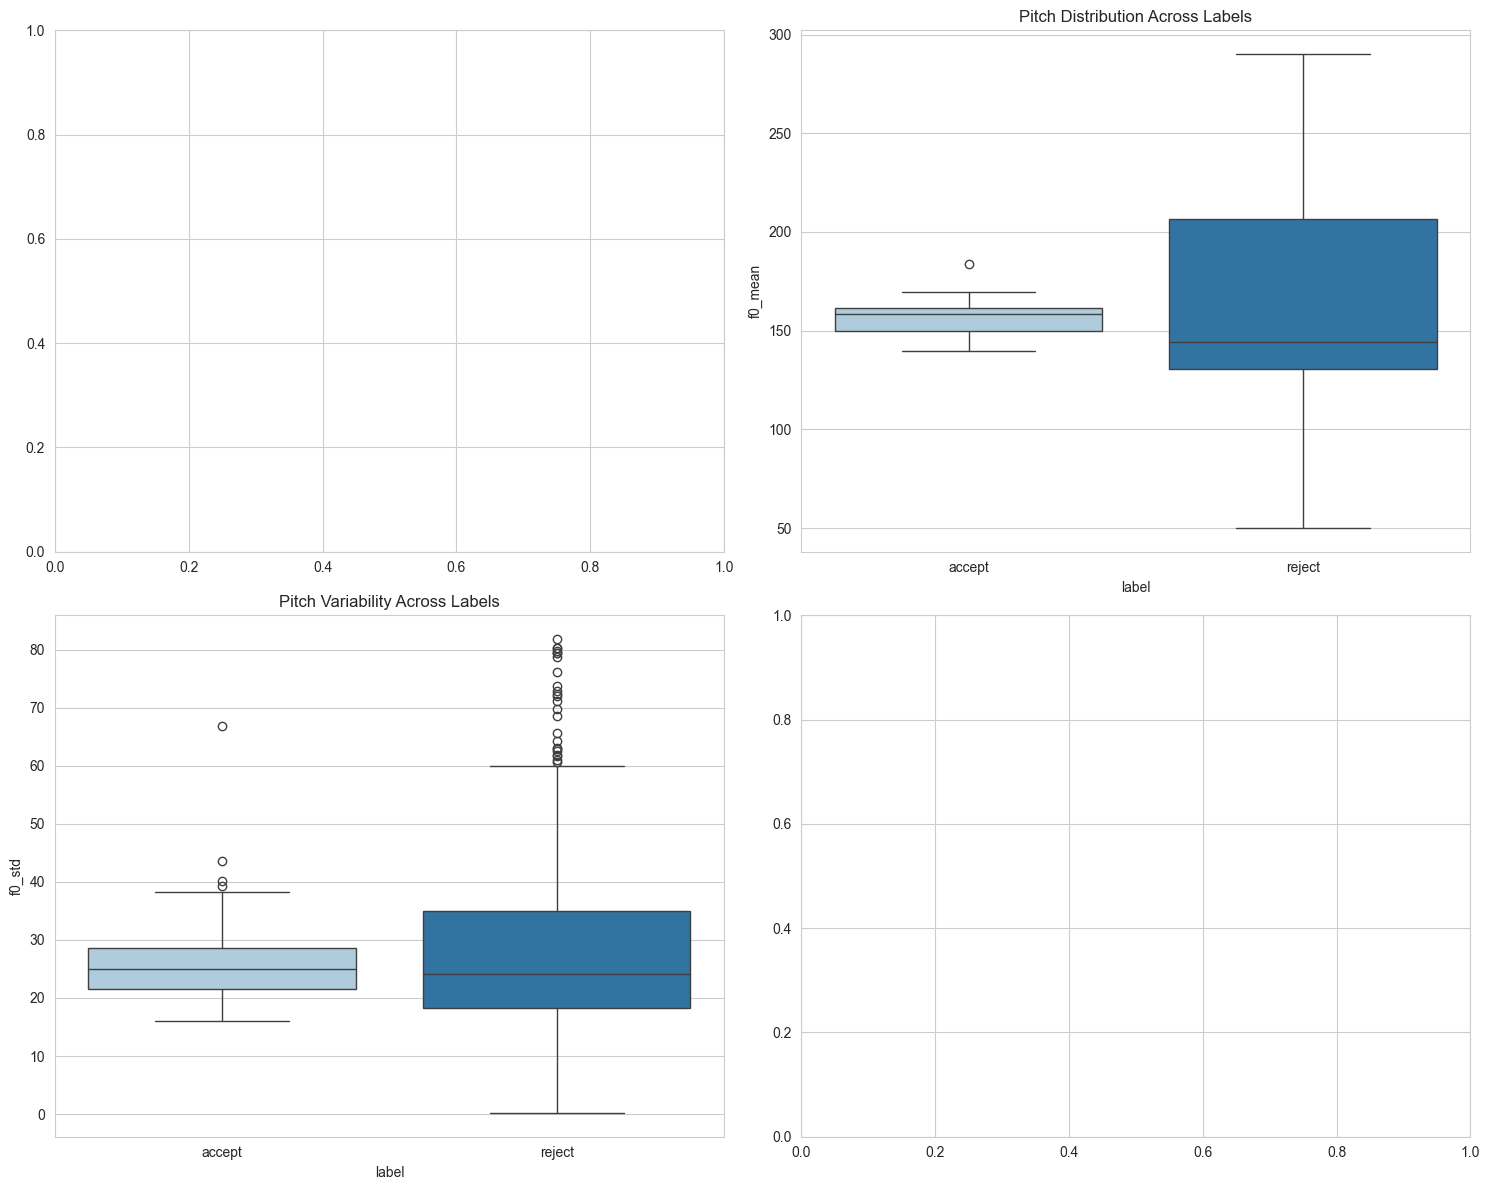

In [16]:
# Pitch analysis
if not features_df.empty and 'f0_mean' in features_df.columns:
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # F0 mean by place
    if 'place' in features_df.columns:
        place_data = features_df[features_df['place'].notna() & (features_df['place'] != 'unknown') & features_df['f0_mean'].notna()]
        if len(place_data) > 0 and len(place_data['place'].unique()) > 1:
            sns.barplot(x="place", y="f0_mean", data=place_data, palette="Paired", ax=axes[0, 0])
            axes[0, 0].set_title("Average Pitch per Place")
            axes[0, 0].tick_params(axis='x', rotation=45)
    
    # F0 mean by label
    if 'label' in features_df.columns:
        label_data = features_df[features_df['f0_mean'].notna()]
        if len(label_data) > 0 and len(label_data['label'].unique()) > 1:
            sns.boxplot(x="label", y="f0_mean", data=label_data, palette="Paired", ax=axes[0, 1])
            axes[0, 1].set_title("Pitch Distribution Across Labels")
    
    # F0 std by label (pitch variability)
    if 'label' in features_df.columns and 'f0_std' in features_df.columns:
        label_data = features_df[features_df['f0_std'].notna()]
        if len(label_data) > 0 and len(label_data['label'].unique()) > 1:
            sns.boxplot(x="label", y="f0_std", data=label_data, palette="Paired", ax=axes[1, 0])
            axes[1, 0].set_title("Pitch Variability Across Labels")
    
    # Frequency distribution by place
    if 'place' in features_df.columns:
        place_data = features_df[features_df['place'].notna() & (features_df['place'] != 'unknown') & features_df['f0_mean'].notna()]
        if len(place_data) > 0 and len(place_data['place'].unique()) > 1:
            sns.histplot(data=place_data, x='f0_mean', hue='place', kde=True, palette='Set2', bins=30, ax=axes[1, 1])
            axes[1, 1].set_title("Frequency Distribution by Place (f0_mean)")
            axes[1, 1].set_xlabel("Average Fundamental Frequency (Hz)")
            axes[1, 1].set_ylabel("Count")
    
    plt.tight_layout()
    plt.show()
else:
    print("No pitch (F0) data available for analysis")


### Results: Pitch Analysis (Accept vs Reject)

These box plots compare fundamental frequency (F0) characteristics between "accept" and "reject" audio files. F0 represents the perceived pitch of a voice and is a crucial feature for understanding vocal characteristics.

### 1. Mean Pitch Distribution (`f0_mean`)

This plot shows the distribution of the *mean* fundamental frequency for each label, representing the average pitch across each audio file.

- **Accept files (light blue)**:
  - **Median**: ~155-160 Hz
  - **IQR**: Very narrow (150-165 Hz), indicating consistent average pitch
  - **Range**: ~140-170 Hz (whiskers)
  - **Outliers**: One outlier at ~185 Hz

- **Reject files (dark blue)**:
  - **Median**: ~140 Hz (lower than accept)
  - **IQR**: Much wider (130-205 Hz), showing greater pitch diversity
  - **Range**: ~50-290 Hz (whiskers), covering a very wide range
  - **Outliers**: No explicit outliers beyond whiskers, but the extensive range itself highlights high variability

**Interpretation**: Accept files have a higher and more consistent average pitch (typical adult speech range). Reject files show lower median pitch but much greater diversity, ranging from very low (possibly non-speech sounds or different voice types) to quite high. This suggests reject audio contains a wider variety of vocalizations or non-speech sounds with different pitch characteristics.

### 2. Pitch Variability (`f0_std`)

This plot shows the *standard deviation* of fundamental frequency, measuring how much pitch varies within each audio file. Higher values indicate more dynamic or fluctuating pitch.

- **Accept files (light blue)**:
  - **Median**: ~25 Hz
  - **IQR**: Relatively tight (22-28 Hz)
  - **Range**: ~15-38 Hz (whiskers)
  - **Outliers**: Several outliers at ~42 Hz and ~67 Hz

- **Reject files (dark blue)**:
  - **Median**: ~22 Hz (slightly lower than accept)
  - **IQR**: Wider (18-35 Hz)
  - **Range**: ~0-60 Hz (whiskers)
  - **Outliers**: Many outliers from ~60-80 Hz, representing extremely high pitch variability

**Interpretation**: While accept files have slightly higher median pitch variability, reject files show a much wider spread. The presence of many high-variability outliers in reject files suggests they often contain more dynamic pitch changes, possibly due to expressive speech, singing, or non-speech sounds with varying frequencies. The lower whisker reaching near 0 Hz in reject files indicates some recordings have very stable (monotone) pitch or contain long unvoiced segments (silence, noise, or non-vocal sounds).

### Key Takeaways


1. **Content diversity**: The wide range of pitch characteristics in reject files suggests they may contain various types of audio: different voice types, non-speech sounds, expressive speech, or mixed content
2. **Data characteristics**: The consistent pitch in accept files aligns with expectations for high-quality voice recordings, while the variability in reject files may indicate different recording conditions, content types, or quality levels

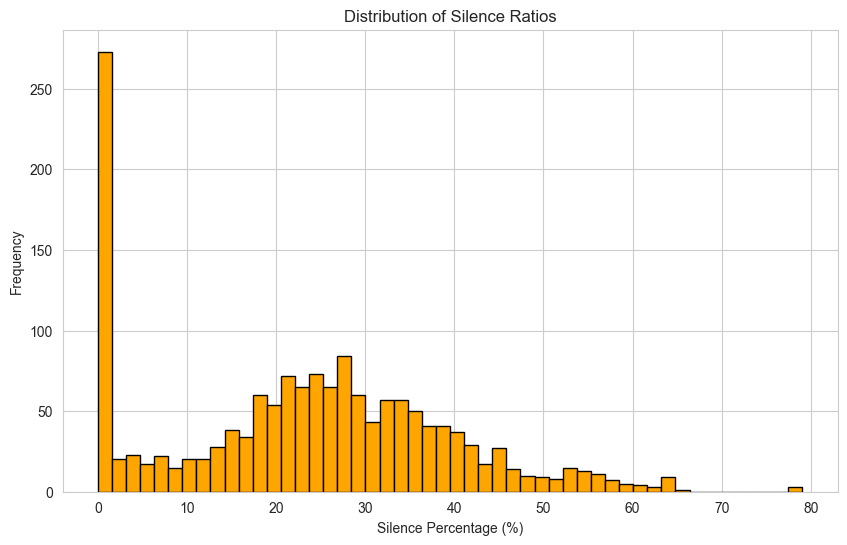

Silence Ratios (Min, Max, Mean): 0.00%, 79.04%, 23.19%


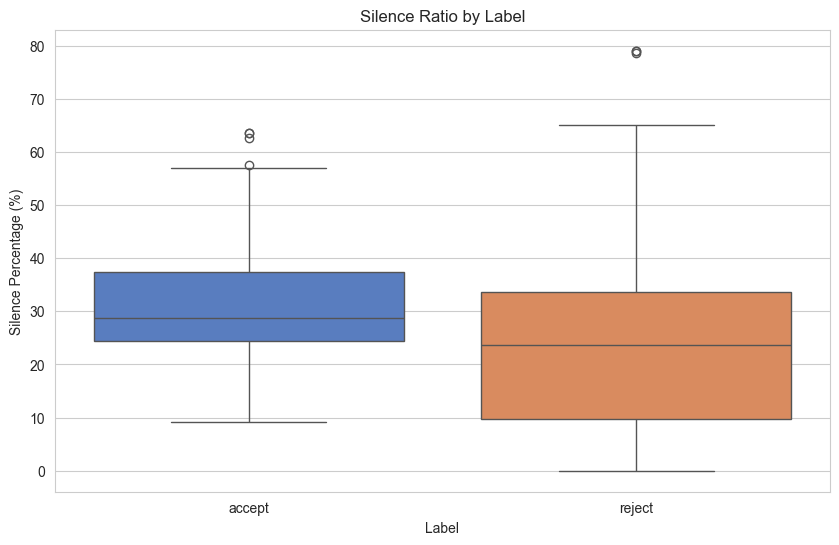

In [18]:
# Silence analysis
def analyze_silence(audio_data, sr=16000, top_db=20):
    """Analyze and visualize the silence ratio (percentage) for all audio files."""
    silence_ratios = []
    
    for item in audio_data:
        y = item['audio']
        file_name = item['file_name']
        label = item.get('label', 'unknown')
        
        try:
            # Split audio into non-silent intervals
            non_silent_intervals = librosa.effects.split(y, top_db=top_db)
            non_silent_duration = sum((end - start) for start, end in non_silent_intervals)
            total_duration = len(y)
            silence_ratio = 1 - (non_silent_duration / total_duration)
            silence_ratios.append({
                'file_name': file_name,
                'label': label,
                'silence_ratio': silence_ratio * 100
            })
        except Exception as e:
            print(f"Error analyzing silence for {file_name}: {e}")
    
    if silence_ratios:
        silence_df = pd.DataFrame(silence_ratios)
        
        # Plot the silence ratio distribution
        plt.figure(figsize=(10, 6))
        plt.hist(silence_df["silence_ratio"], bins=50, color='orange', edgecolor='black')
        plt.title("Distribution of Silence Ratios")
        plt.xlabel("Silence Percentage (%)")
        plt.ylabel("Frequency")
        plt.show()
        
        print(f"Silence Ratios (Min, Max, Mean): {silence_df['silence_ratio'].min():.2f}%, "
              f"{silence_df['silence_ratio'].max():.2f}%, {silence_df['silence_ratio'].mean():.2f}%")
        
        # Silence ratio by label
        if len(silence_df['label'].unique()) > 1:
            plt.figure(figsize=(10, 6))
            sns.boxplot(data=silence_df, x='label', y='silence_ratio', palette='muted')
            plt.title("Silence Ratio by Label")
            plt.xlabel("Label")
            plt.ylabel("Silence Percentage (%)")
            plt.show()
        
        return silence_df
    else:
        print("No silence data available")
        return pd.DataFrame()

if full_audio_data:
    silence_df = analyze_silence(full_audio_data)
else:
    print("No audio data available for silence analysis")


### Results: Distribution of Silence Ratios

This histogram displays the frequency of different "Silence Percentage (%)" values found in the audio dataset. The silence percentage represents the proportion of silence detected within an audio recording.

### Overall Distribution Shape

- **X-axis**: Silence Percentage (%), ranging from 0% to 80% (bins approximately 1-2% wide)
- **Y-axis**: Frequency (count of audio files), ranging from 0 to over 250
- **Distribution Type**: Heavily right-skewed with a prominent peak at low silence percentages

### Key Features

1. **Dominant Peak at 0-2% Silence**:
   - The first bar (0-2% silence) has the highest frequency, exceeding 270 files
   - Indicates that a large number of recordings contain very little to no detected silence
   - Suggests either continuous speech/sound or pre-processed files with silence removed

2. **Rapid Decline after Initial Peak**:
   - Frequency drops sharply after the first bin
   - Bins for 2-4% and 4-6% silence have frequencies below 20
   - Shows a clear separation between "full" recordings and those with moderate silence

3. **Secondary Peak/Plateau (18-30% Silence)**:
   - Gradual increase forming a broader, lower peak in the 18-30% range
   - Several bins in this range have frequencies between 50-80
   - Peak around 28-30% silence with frequency close to 80
   - Represents recordings with moderate amounts of silence (natural pauses, background noise, or intermittent content)

4. **Long Tail Distribution**:
   - Frequencies gradually decrease as silence percentage increases
   - Drops below 50 for silence percentages above 35%
   - Drops below 20 for silence percentages above 50%

5. **Sparse Data at High Silence Percentages**:
   - Very few recordings with high silence percentages
   - Only a handful of files between 60-70% silence
   - One isolated bar around 78-80% silence (possibly nearly empty or very noisy recordings)

### Interpretation

1. **Many "Full" Recordings**: The overwhelming majority of audio files have very little silence (<2%), suggesting they are either:
   - Continuous speech/sound recordings
   - Pre-processed files with silence already removed
   - High-quality recordings with minimal gaps

2. **Variability in Silence Content**: A significant portion of files (15-40% silence) contains moderate amounts of silence, which could represent:
   - Natural pauses in speech
   - Background noise or quiet segments
   - Intermittent audio content
   - Different recording conditions or content types

3. **Potential Data Quality Issues**: The few files with very high silence percentages (60-80%) might be:
   - Nearly empty recordings
   - Very noisy files where silence detection struggled
   - Recordings with extremely long pauses
   - Candidates for further investigation or removal

4. **Impact on Segmentation**: This distribution is crucial for understanding:
   - Files with low silence percentages will yield more active segments during segmentation
   - Files with higher percentages might yield fewer or shorter active segments
   - Segmentation strategy should account for this bimodal distribution pattern

### Key Takeaways

- **Bimodal Pattern**: The distribution shows two main groups: files with minimal silence and files with moderate silence
- **Data Quality**: Most recordings appear to be high-quality with minimal silence, supporting the "accept" classification
- **Segmentation Considerations**: The variability in silence content should be considered when designing segmentation and preprocessing pipelines
- **Outlier Investigation**: Files with extremely high silence percentages (>60%) should be reviewed for potential removal or special handling

### Results: Silence Ratio by Label

This box plot visualizes the distribution of "Silence Percentage (%)" for audio files categorized by their "Label": "accept" and "reject". The silence percentage indicates the proportion of silence detected within an audio recording.

### Analysis of "Accept" Label (Blue Box Plot)

- **Median**: Approximately **29%** silence
- **Interquartile Range (IQR)**: 25-37% (width of ~12 percentage points)
  - 25th percentile: ~25%
  - 75th percentile: ~37%
  - The middle 50% of accept files have relatively consistent silence ratios
- **Whiskers**:
  - Lower whisker: ~9%
  - Upper whisker: ~57%
  - Most accept files (excluding outliers) have silence percentages between 9% and 57%
- **Outliers**: Three outliers above the upper whisker:
  - One around **58%**
  - Two clustered around **63%**

### Analysis of "Reject" Label (Orange Box Plot)

- **Median**: Approximately **24%** silence (slightly lower than accept)
- **Interquartile Range (IQR)**: 10-33% (width of ~23 percentage points)
  - 25th percentile: ~10%
  - 75th percentile: ~33%
  - The middle 50% of reject files show greater variability
- **Whiskers**:
  - Lower whisker: ~0% (or very close to it)
  - Upper whisker: ~65%
  - Most reject files (excluding outliers) have silence percentages between 0% and 65%
- **Outliers**: One outlier above the upper whisker:
  - One around **79%** (extremely high silence percentage)

### Comparison and Interpretation

1. **Median Silence**: Accept files have a slightly higher median silence percentage (29%) compared to reject files (24%), but the difference is relatively small

2. **Variability (IQR)**: 
   - **Accept files**: Much tighter IQR (25-37%), indicating more consistent silence ratios in the central 50% of files
   - **Reject files**: Wider IQR (10-33%), showing greater variability in silence content

3. **Overall Range**:
   - **Accept files**: Narrower range (9-57% for whiskers), with outliers up to 63%
   - **Reject files**: Broader range (0-65% for whiskers), with an extreme outlier at 79%

4. **Extreme Cases**:
   - The reject category contains a file with ~79% silence, significantly higher than any accept file
   - This suggests some reject recordings are predominantly silent, possibly indicating:
     - Nearly empty recordings
     - Very noisy files where silence detection struggled
     - Recordings with extremely long pauses

5. **Distribution Characteristics**:
   - **Accept files**: More concentrated distribution, generally falling within a moderate range (9-57%)
   - **Reject files**: More diverse distribution, including both very low (near 0%) and very high (up to 79%) silence percentages

### Key Takeaways

1. **Similar Medians, Different Spreads**: While both classes have similar median silence percentages, reject files show much greater variability
2. **Consistency**: Accept files demonstrate more consistent silence ratios, which may indicate more uniform recording quality or content type
3. **Data Quality**: The extreme outlier in reject files (79% silence) suggests potential data quality issues that may need investigation
4. **Content Diversity**: The wider range in reject files suggests more diverse audio content, including files with minimal silence and files that are predominantly silent
5. **Classification Potential**: The difference in variability could be a useful feature for classification, as accept files tend to cluster more tightly around moderate silence percentages

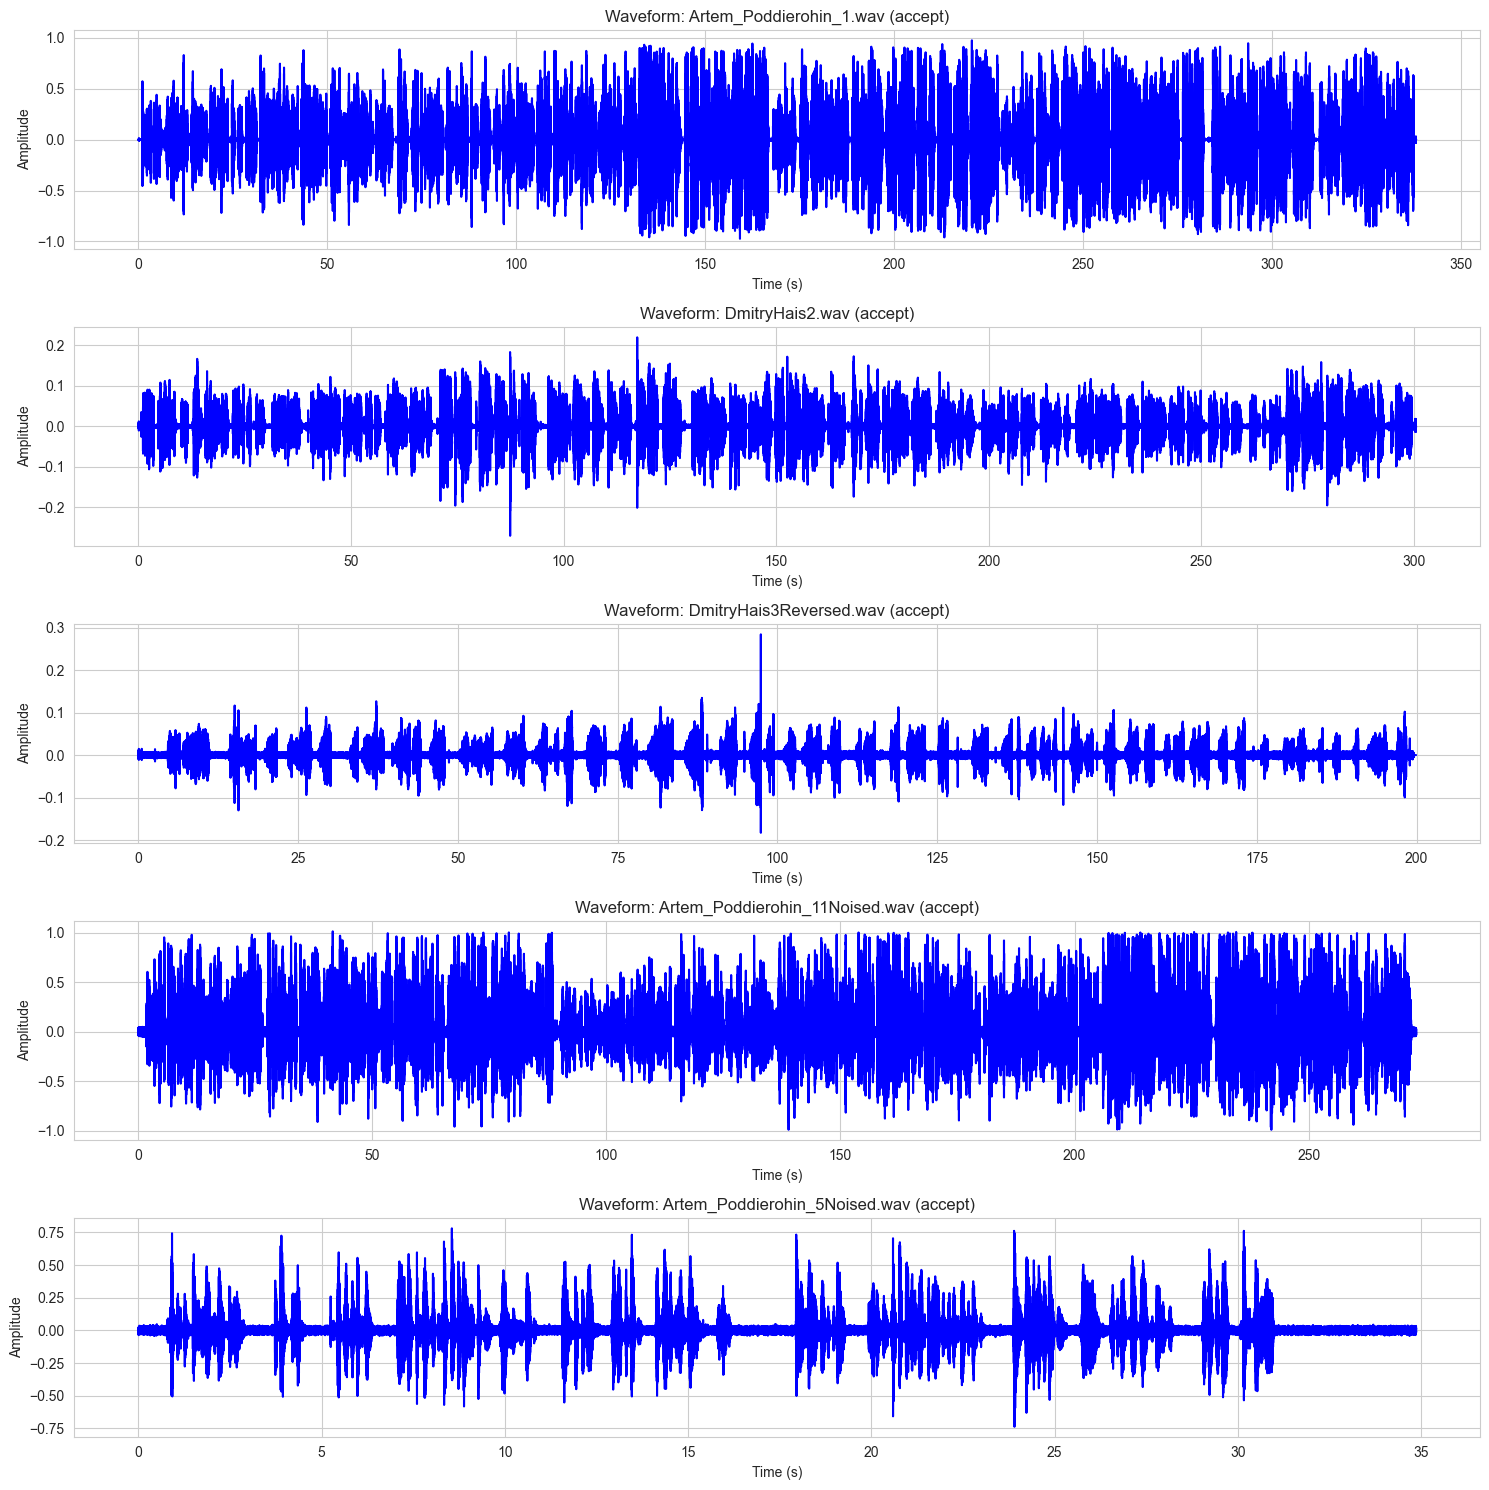

In [19]:
# Waveform visualization
def plot_waveforms(audio_data, num_samples=5):
    """Plot waveforms of selected audio samples."""
    plt.figure(figsize=(15, num_samples * 3))
    for i, item in enumerate(audio_data[:num_samples]):
        y = item['audio']
        sr = item['sr']
        label = item.get('label', 'unknown')
        file_name = item['file_name']
        
        plt.subplot(num_samples, 1, i + 1)
        time_axis = np.arange(len(y)) / sr
        plt.plot(time_axis, y, color='blue')
        plt.title(f"Waveform: {file_name} ({label})")
        plt.xlabel("Time (s)")
        plt.ylabel("Amplitude")
    plt.tight_layout()
    plt.show()

if full_audio_data:
    plot_waveforms(full_audio_data, num_samples=min(5, len(full_audio_data)))
else:
    print("No audio data available for waveform visualization")


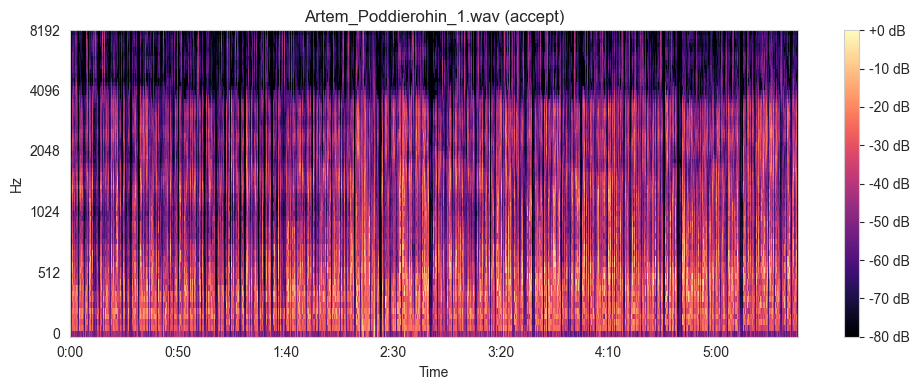

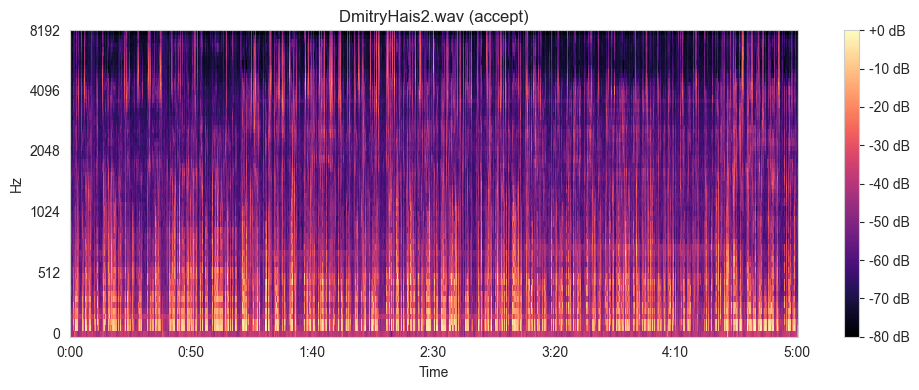

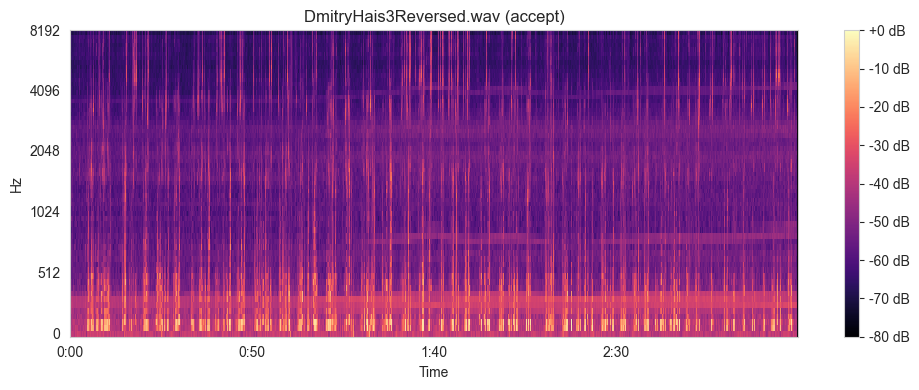

In [20]:
# Spectrogram examples
def plot_spectrogram(y, sr, title):
    """Plot mel spectrogram of an audio signal."""
    plt.figure(figsize=(10, 4))
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=64, fmax=8000)
    S_dB = librosa.power_to_db(S, ref=np.max)
    librosa.display.specshow(S_dB, sr=sr, x_axis="time", y_axis="mel", fmax=8000)
    plt.colorbar(format="%+2.0f dB")
    plt.title(title)
    plt.tight_layout()
    plt.show()

# Plot spectrograms for samples from different labels
if full_audio_data:
    # Get samples from different labels
    labels_seen = set()
    samples_to_plot = []
    for item in full_audio_data:
        label = item.get('label', 'unknown')
        if label not in labels_seen or len(samples_to_plot) < 3:
            samples_to_plot.append(item)
            labels_seen.add(label)
        if len(samples_to_plot) >= 3:
            break
    
    for item in samples_to_plot:
        plot_spectrogram(
            item['audio'], 
            item['sr'], 
            title=f"{item['file_name']} ({item.get('label', 'unknown')})"
        )
else:
    print("No audio data available for spectrogram visualization")


## 3. EDA on Segments and Spectrograms


In [21]:
# Load segmented audio files
def load_segmented_audio(audio_dir, sr=16000):
    """Load segmented audio files from subdirectories."""
    segment_data = []
    audio_extensions = {'.wav', '.mp3', '.flac', '.m4a', '.ogg'}
    
    if not audio_dir.exists():
        print(f"Audio directory not found: {audio_dir}")
        return segment_data
    
    # Look for subdirectories (each might be a different clip set)
    for subdir in audio_dir.iterdir():
        if subdir.is_dir() and subdir.name != '__pycache__':
            print(f"Loading segments from: {subdir.name}")
            for audio_file in subdir.rglob('*'):
                if audio_file.suffix.lower() in audio_extensions:
                    try:
                        y, sample_rate = librosa.load(str(audio_file), sr=sr)
                        file_name = audio_file.name
                        
                        # Try to extract label from filename (common patterns: accept_*, reject_*)
                        label = 'unknown'
                        if 'accept' in file_name.lower():
                            label = 'accept'
                        elif 'reject' in file_name.lower():
                            label = 'reject'
                        
                        # Try to extract speaker info from filename if possible
                        speaker = None
                        # Common pattern: speaker_filename or speaker_filename_*
                        parts = file_name.split('_')
                        if len(parts) > 1:
                            # Heuristic: if first part looks like a speaker ID
                            potential_speaker = parts[0]
                            if len(potential_speaker) <= 10 and potential_speaker.isalnum():
                                speaker = potential_speaker
                        
                        segment_data.append({
                            'file_path': str(audio_file),
                            'file_name': file_name,
                            'label': label,
                            'speaker': speaker,
                            'audio': y,
                            'sr': sample_rate,
                            'duration': len(y) / sample_rate,
                            'num_samples': len(y)
                        })
                    except Exception as e:
                        print(f"Failed to load {audio_file}: {e}")
    
    print(f"\n{'='*50}")
    print(f"Loaded {len(segment_data)} segment(s)")
    print(f"{'='*50}")
    return segment_data

# Load segments
segmented_audio_data = load_segmented_audio(AUDIO_DIR)


Loading segments from: clips_lowerres



Loaded 13245 segment(s)


In [22]:
# Analyze segments: compute amplitude statistics
if segmented_audio_data:
    print("Computing segment statistics...")
    segment_stats = []
    
    for item in segmented_audio_data:
        y = item['audio']
        stats = {
            'file_name': item['file_name'],
            'label': item['label'],
            'speaker': item.get('speaker', 'unknown'),
            'duration': item['duration'],
            'num_samples': item['num_samples'],
            'mean_amplitude': np.mean(np.abs(y)),
            'max_amplitude': np.max(np.abs(y)),
            'std_amplitude': np.std(y),
            'rms': np.sqrt(np.mean(y**2))
        }
        segment_stats.append(stats)
    
    segment_stats_df = pd.DataFrame(segment_stats)
    print(f"\nSegment Statistics DataFrame shape: {segment_stats_df.shape}")
    print(segment_stats_df.head())
    
    # Check segment length consistency
    print("\n" + "="*60)
    print("SEGMENT LENGTH CONSISTENCY CHECK")
    print("="*60)
    print(f"Number of unique durations: {segment_stats_df['duration'].nunique()}")
    print(f"Duration statistics:")
    print(segment_stats_df['duration'].describe())
    print(f"\nNumber of unique sample counts: {segment_stats_df['num_samples'].nunique()}")
    print(f"Sample count statistics:")
    print(segment_stats_df['num_samples'].describe())
    
    # Check if segments are consistent (within 1% variation)
    duration_std = segment_stats_df['duration'].std()
    duration_mean = segment_stats_df['duration'].mean()
    if duration_mean > 0:
        cv = (duration_std / duration_mean) * 100
        print(f"\nCoefficient of Variation: {cv:.2f}%")
        if cv < 1.0:
            print("✓ Segments have consistent length (CV < 1%)")
        else:
            print(f"⚠ Segments vary in length (CV = {cv:.2f}%)")
else:
    print("No segmented audio files found")
    segment_stats_df = pd.DataFrame()


Computing segment statistics...

Segment Statistics DataFrame shape: (13245, 9)
                                     file_name   label speaker  duration  \
0    accept_Artem_Poddierohin_1Noised_0029.wav  accept  accept       3.0   
1             accept_Yurii_Demoshenko_0101.wav  accept  accept       3.0   
2  accept_Artem_Poddierohin_3Reversed_0024.wav  accept  accept       3.0   
3                  reject_Ihor1Noised_0001.wav  reject  reject       3.0   
4       reject_NataliePortmanReversed_0025.wav  reject  reject       3.0   

   num_samples  mean_amplitude  max_amplitude  std_amplitude       rms  
0        48000        0.039018       0.869923       0.067335  0.067335  
1        48000        0.019516       0.290561       0.030803  0.030803  
2        48000        0.069253       0.872758       0.118442  0.118442  
3        48000        0.013340       0.243275       0.028349  0.028349  
4        48000        0.016808       0.406597       0.033375  0.033375  

SEGMENT LENGTH CONSISTEN

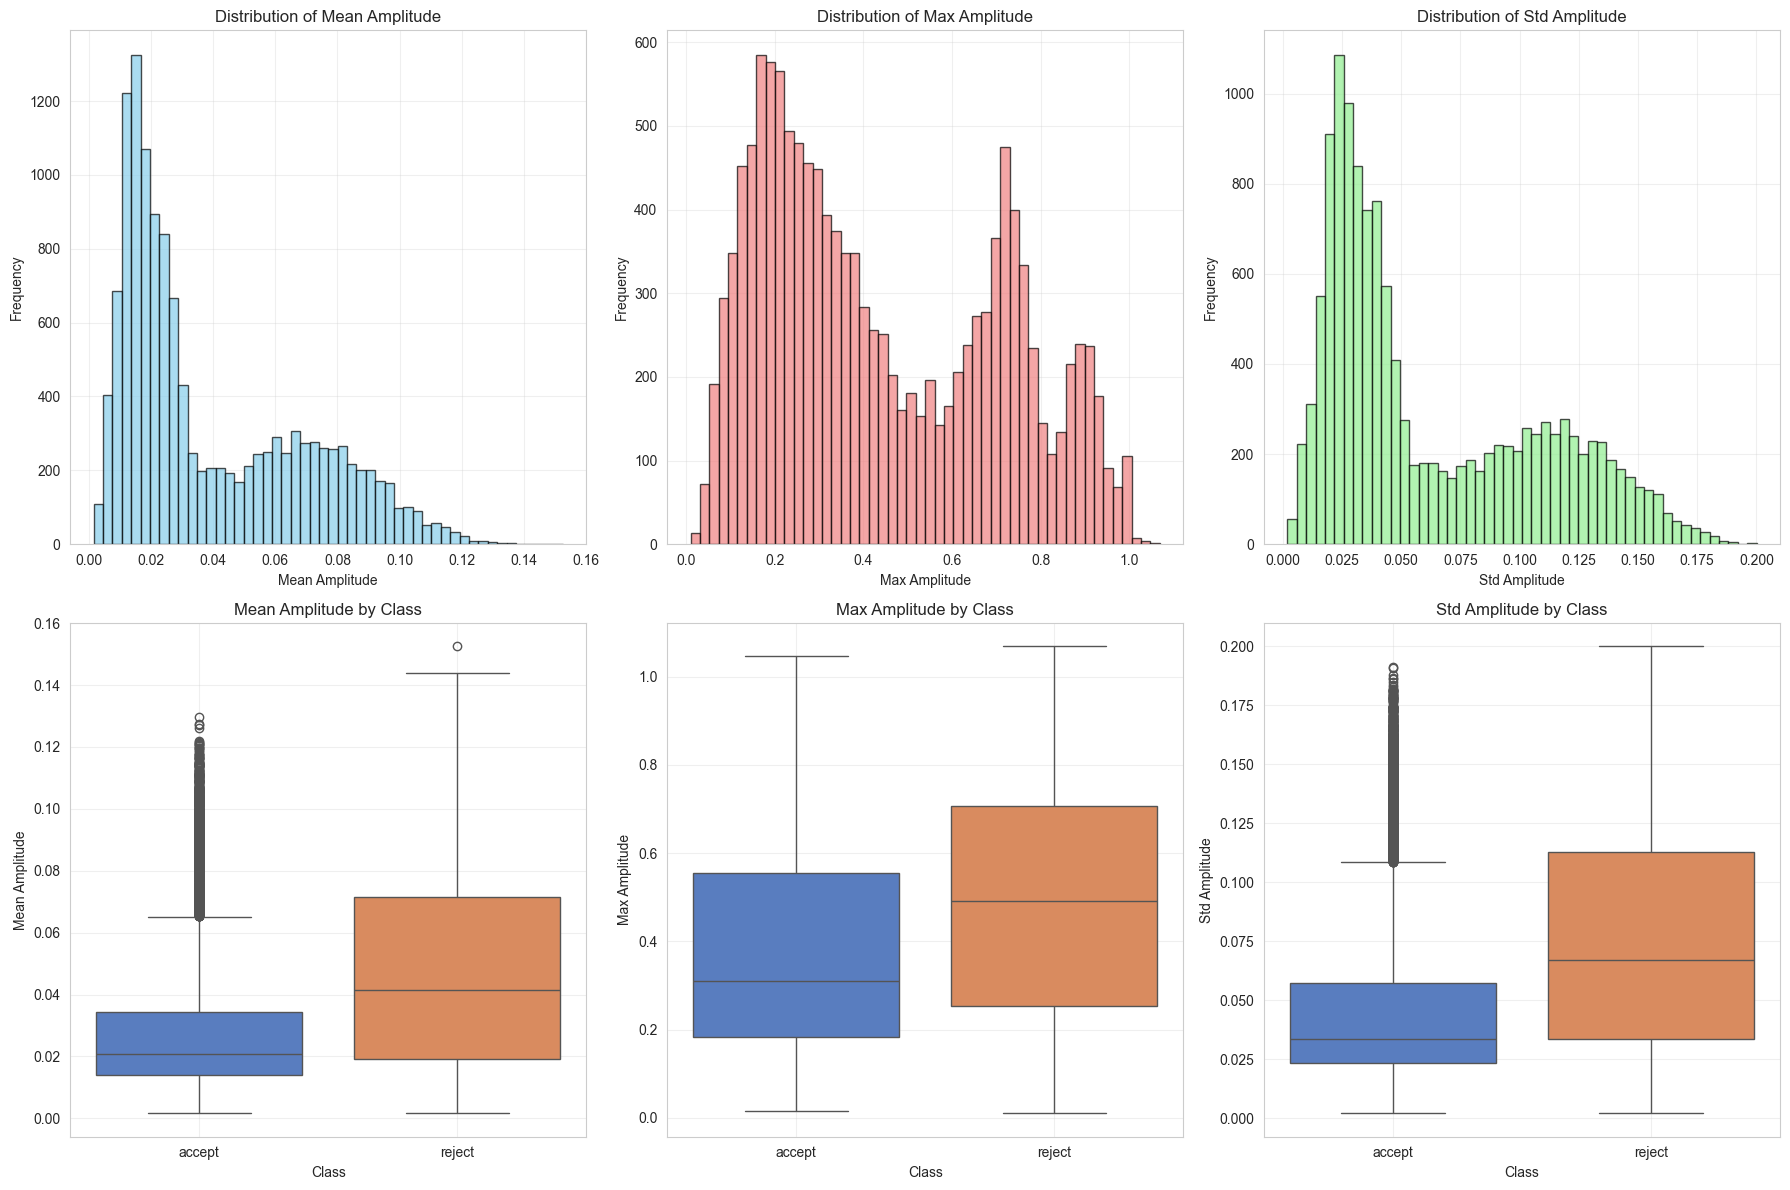

In [23]:
# Visualize segment statistics
if not segment_stats_df.empty:
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    # Histogram of mean amplitude
    axes[0, 0].hist(segment_stats_df['mean_amplitude'], bins=50, edgecolor='black', alpha=0.7, color='skyblue')
    axes[0, 0].set_title('Distribution of Mean Amplitude')
    axes[0, 0].set_xlabel('Mean Amplitude')
    axes[0, 0].set_ylabel('Frequency')
    axes[0, 0].grid(True, alpha=0.3)
    
    # Histogram of max amplitude
    axes[0, 1].hist(segment_stats_df['max_amplitude'], bins=50, edgecolor='black', alpha=0.7, color='lightcoral')
    axes[0, 1].set_title('Distribution of Max Amplitude')
    axes[0, 1].set_xlabel('Max Amplitude')
    axes[0, 1].set_ylabel('Frequency')
    axes[0, 1].grid(True, alpha=0.3)
    
    # Histogram of std amplitude
    axes[0, 2].hist(segment_stats_df['std_amplitude'], bins=50, edgecolor='black', alpha=0.7, color='lightgreen')
    axes[0, 2].set_title('Distribution of Std Amplitude')
    axes[0, 2].set_xlabel('Std Amplitude')
    axes[0, 2].set_ylabel('Frequency')
    axes[0, 2].grid(True, alpha=0.3)
    
    # Mean amplitude by class
    if len(segment_stats_df['label'].unique()) > 1:
        sns.boxplot(data=segment_stats_df, x='label', y='mean_amplitude', ax=axes[1, 0], palette='muted')
        axes[1, 0].set_title('Mean Amplitude by Class')
        axes[1, 0].set_xlabel('Class')
        axes[1, 0].set_ylabel('Mean Amplitude')
        axes[1, 0].grid(True, alpha=0.3)
    
    # Max amplitude by class
    if len(segment_stats_df['label'].unique()) > 1:
        sns.boxplot(data=segment_stats_df, x='label', y='max_amplitude', ax=axes[1, 1], palette='muted')
        axes[1, 1].set_title('Max Amplitude by Class')
        axes[1, 1].set_xlabel('Class')
        axes[1, 1].set_ylabel('Max Amplitude')
        axes[1, 1].grid(True, alpha=0.3)
    
    # Std amplitude by class
    if len(segment_stats_df['label'].unique()) > 1:
        sns.boxplot(data=segment_stats_df, x='label', y='std_amplitude', ax=axes[1, 2], palette='muted')
        axes[1, 2].set_title('Std Amplitude by Class')
        axes[1, 2].set_xlabel('Class')
        axes[1, 2].set_ylabel('Std Amplitude')
        axes[1, 2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
else:
    print("No segment data to visualize")


### Results: Segment Amplitude Statistics (Accept vs Reject)

### Overall Distributions (Top Row)

1. **Mean Amplitude**: Heavily right-skewed with a strong peak at 0.01-0.02, indicating most segments have very low average amplitude
2. **Max Amplitude**: Bimodal distribution with peaks around 0.15-0.25 and 0.7-0.8, suggesting two distinct groups of segments
3. **Std Amplitude**: Bimodal with a primary peak at 0.02-0.03 and a broader hump from 0.075-0.15

### Class Comparison (Bottom Row)

**Mean Amplitude**:
- **Accept**: Lower median (~0.02), tighter IQR (0.01-0.035), many outliers up to 0.125
- **Reject**: Higher median (~0.04), wider IQR (0.02-0.07), fewer outliers

**Max Amplitude**:
- **Accept**: Lower median (~0.3), IQR: 0.18-0.57, full range (0-1.0)
- **Reject**: Higher median (~0.5), IQR: 0.25-0.7, full range (0-1.0)

**Std Amplitude**:
- **Accept**: Lower median (~0.035), tighter IQR (0.015-0.055), many outliers up to 0.19
- **Reject**: Higher median (~0.065), wider IQR (0.03-0.11), no outliers

### Key Takeaways

- **Reject segments** consistently show higher amplitude values (mean, max, std) and greater variability
- **Accept segments** have lower, more consistent amplitudes with many high-variability outliers
- The bimodal distributions suggest distinct subgroups within the dataset
- These amplitude features are discriminative and could be useful for classification

In [24]:
# Load and analyze spectrograms
def load_spectrogram_images(spectrogram_dir):
    """Load spectrogram image files."""
    spectrogram_data = []
    
    if not spectrogram_dir.exists():
        print(f"Spectrogram directory not found: {spectrogram_dir}")
        return spectrogram_data
    
    # Look for subdirectories
    for subdir in spectrogram_dir.iterdir():
        if subdir.is_dir():
            print(f"Loading spectrograms from: {subdir.name}")
            for img_file in subdir.rglob('*.png'):
                try:
                    img = Image.open(img_file)
                    img_array = np.array(img)
                    
                    # Extract label from filename
                    label = 'unknown'
                    file_name = img_file.name
                    if 'accept' in file_name.lower():
                        label = 'accept'
                    elif 'reject' in file_name.lower():
                        label = 'reject'
                    
                    # Extract speaker if possible
                    speaker = None
                    parts = file_name.split('_')
                    if len(parts) > 1:
                        potential_speaker = parts[0]
                        if len(potential_speaker) <= 10 and potential_speaker.isalnum():
                            speaker = potential_speaker
                    
                    spectrogram_data.append({
                        'file_path': str(img_file),
                        'file_name': file_name,
                        'label': label,
                        'speaker': speaker,
                        'image': img_array,
                        'shape': img_array.shape
                    })
                except Exception as e:
                    print(f"Failed to load {img_file}: {e}")
    
    print(f"\n{'='*50}")
    print(f"Loaded {len(spectrogram_data)} spectrogram(s)")
    print(f"{'='*50}")
    return spectrogram_data

# Load spectrograms
spectrogram_data = load_spectrogram_images(SPECTROGRAM_DIR)


Loading spectrograms from: specs_lowQuality

Loaded 13245 spectrogram(s)


In [25]:
# Analyze spectrogram pixel intensities
if spectrogram_data:
    print("Analyzing spectrogram pixel intensities...")
    spectrogram_stats = []
    
    for item in spectrogram_data:
        img_array = item['image']
        
        # Convert to grayscale if RGB
        if len(img_array.shape) == 3:
            # RGB image
            gray = np.mean(img_array, axis=2).astype(np.uint8)
            rgb_stats = {
                'r_mean': np.mean(img_array[:, :, 0]),
                'g_mean': np.mean(img_array[:, :, 1]),
                'b_mean': np.mean(img_array[:, :, 2]),
                'r_std': np.std(img_array[:, :, 0]),
                'g_std': np.std(img_array[:, :, 1]),
                'b_std': np.std(img_array[:, :, 2])
            }
        else:
            # Grayscale image
            gray = img_array
            rgb_stats = {
                'r_mean': np.nan, 'g_mean': np.nan, 'b_mean': np.nan,
                'r_std': np.nan, 'g_std': np.nan, 'b_std': np.nan
            }
        
        stats = {
            'file_name': item['file_name'],
            'label': item['label'],
            'speaker': item.get('speaker', 'unknown'),
            'pixel_intensity_mean': np.mean(gray),
            'pixel_intensity_std': np.std(gray),
            'pixel_intensity_min': np.min(gray),
            'pixel_intensity_max': np.max(gray),
            'is_rgb': len(img_array.shape) == 3,
            **rgb_stats
        }
        spectrogram_stats.append(stats)
    
    spectrogram_stats_df = pd.DataFrame(spectrogram_stats)
    print(f"\nSpectrogram Statistics DataFrame shape: {spectrogram_stats_df.shape}")
    print(spectrogram_stats_df.head())
    
    # Summarize spectrograms
    print("\n" + "="*60)
    print("SPECTROGRAM SUMMARY")
    print("="*60)
    print(f"Number of spectrograms per class:")
    print(spectrogram_stats_df['label'].value_counts())
    
    if 'speaker' in spectrogram_stats_df.columns:
        speaker_data = spectrogram_stats_df[spectrogram_stats_df['speaker'].notna()]
        if len(speaker_data) > 0:
            print(f"\nNumber of spectrograms per speaker (top 10):")
            print(speaker_data['speaker'].value_counts().head(10))
    
    print(f"\nPixel intensity statistics:")
    print(spectrogram_stats_df[['pixel_intensity_mean', 'pixel_intensity_std', 
                                 'pixel_intensity_min', 'pixel_intensity_max']].describe())
else:
    print("No spectrogram files found")
    spectrogram_stats_df = pd.DataFrame()


Analyzing spectrogram pixel intensities...

Spectrogram Statistics DataFrame shape: (13245, 14)
                                       file_name   label speaker  \
0        reject_Veronika_Mark_2Reversed_0015.png  reject  reject   
1                 accept_ValentynNoised_0002.png  accept  accept   
2                accept_Valentyn1Noised_0054.png  accept  accept   
3         reject_linus_2_minuteReversed_0000.png  reject  reject   
4  reject_ObamaSpeech2004DNC_0044Noised_0000.png  reject  reject   

   pixel_intensity_mean  pixel_intensity_std  pixel_intensity_min  \
0              138.2131            26.724189                   64   
1              126.1364            32.374771                   64   
2              123.9383            32.673480                   64   
3              141.3553            28.281115                   64   
4              110.4088            30.959594                   64   

   pixel_intensity_max  is_rgb    r_mean   g_mean    b_mean      r_std  \
0     

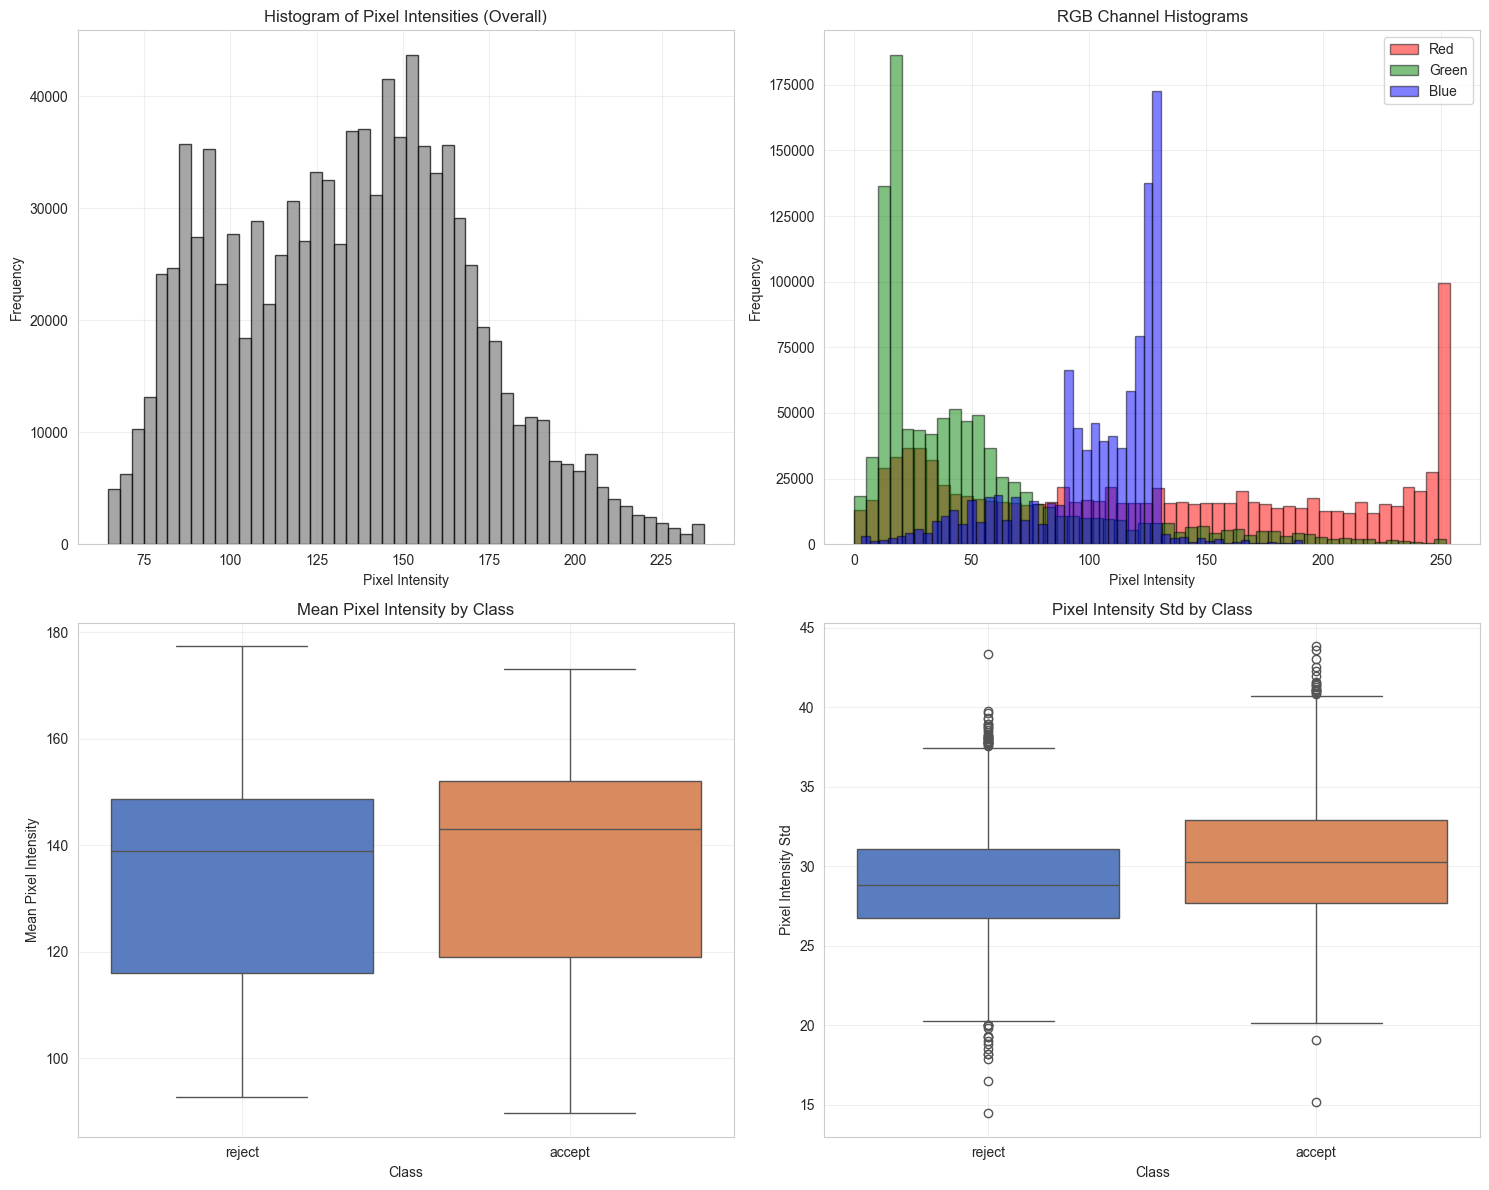

In [26]:
# Visualize spectrogram pixel intensity histograms
if spectrogram_data:
    # Collect all pixel intensities
    all_pixels = []
    rgb_pixels = {'r': [], 'g': [], 'b': []}
    
    for item in spectrogram_data[:100]:  # Sample first 100 for performance
        img_array = item['image']
        if len(img_array.shape) == 3:
            # RGB
            rgb_pixels['r'].extend(img_array[:, :, 0].flatten())
            rgb_pixels['g'].extend(img_array[:, :, 1].flatten())
            rgb_pixels['b'].extend(img_array[:, :, 2].flatten())
            gray = np.mean(img_array, axis=2)
        else:
            gray = img_array
        all_pixels.extend(gray.flatten())
    
    # Plot histograms
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # Overall pixel intensity histogram
    axes[0, 0].hist(all_pixels, bins=50, edgecolor='black', alpha=0.7, color='gray')
    axes[0, 0].set_title('Histogram of Pixel Intensities (Overall)')
    axes[0, 0].set_xlabel('Pixel Intensity')
    axes[0, 0].set_ylabel('Frequency')
    axes[0, 0].grid(True, alpha=0.3)
    
    # RGB channel histograms if available
    if rgb_pixels['r']:
        axes[0, 1].hist(rgb_pixels['r'], bins=50, alpha=0.5, label='Red', color='red', edgecolor='black')
        axes[0, 1].hist(rgb_pixels['g'], bins=50, alpha=0.5, label='Green', color='green', edgecolor='black')
        axes[0, 1].hist(rgb_pixels['b'], bins=50, alpha=0.5, label='Blue', color='blue', edgecolor='black')
        axes[0, 1].set_title('RGB Channel Histograms')
        axes[0, 1].set_xlabel('Pixel Intensity')
        axes[0, 1].set_ylabel('Frequency')
        axes[0, 1].legend()
        axes[0, 1].grid(True, alpha=0.3)
    else:
        axes[0, 1].text(0.5, 0.5, 'No RGB data available\n(Grayscale spectrograms)', 
                       ha='center', va='center', transform=axes[0, 1].transAxes)
        axes[0, 1].set_title('RGB Channel Histograms')
    
    # Pixel intensity by class
    if not spectrogram_stats_df.empty and len(spectrogram_stats_df['label'].unique()) > 1:
        sns.boxplot(data=spectrogram_stats_df, x='label', y='pixel_intensity_mean', 
                   ax=axes[1, 0], palette='muted')
        axes[1, 0].set_title('Mean Pixel Intensity by Class')
        axes[1, 0].set_xlabel('Class')
        axes[1, 0].set_ylabel('Mean Pixel Intensity')
        axes[1, 0].grid(True, alpha=0.3)
    
    # Pixel intensity std by class
    if not spectrogram_stats_df.empty and len(spectrogram_stats_df['label'].unique()) > 1:
        sns.boxplot(data=spectrogram_stats_df, x='label', y='pixel_intensity_std', 
                   ax=axes[1, 1], palette='muted')
        axes[1, 1].set_title('Pixel Intensity Std by Class')
        axes[1, 1].set_xlabel('Class')
        axes[1, 1].set_ylabel('Pixel Intensity Std')
        axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
else:
    print("No spectrogram data to visualize")


### Results: Spectrogram Pixel Intensity Analysis

### Overall Distribution (Top-Left)
- **Multi-modal distribution** with peaks around 90-100, 130-135, and 150
- Most pixels fall within intensity range 75-175
- Bell-shaped but complex, reflecting the varied nature of spectrogram pixel values

### RGB Channel Analysis (Top-Right)
- **Green channel**: Strong peak at very low intensities (0-10), indicating dark/low-energy regions dominate
- **Blue channel**: Peak around 125-130, significant activity in 75-150 range
- **Red channel**: Relatively flat at lower intensities, strong peak at maximum intensity (~250), indicating bright/high-energy regions
- **Color mapping**: Low energy = dark green/black, high energy = bright red/white (typical spectrogram visualization)

### Mean Pixel Intensity by Class (Bottom-Left)
- **Accept**: Median ~143-144, IQR: 120-152
- **Reject**: Median ~140, IQR: 115-150
- **Comparison**: Very similar distributions, accept class slightly brighter on average

### Pixel Intensity Std by Class (Bottom-Right)
- **Accept**: Median ~30, IQR: 28-33, outliers at both extremes
- **Reject**: Median ~29, IQR: 27-31, outliers at both extremes
- **Comparison**: Accept class shows slightly higher variability/contrast in pixel intensities

### Key Takeaways
- Mean pixel intensities are very similar between classes (minimal discriminative power)
- Accept spectrograms have slightly more contrast/variability (higher std)
- RGB histograms reveal the color scheme: dark green for low energy, bright red for high energy
- The multi-modal distribution reflects the complex nature of spectrogram visualizations

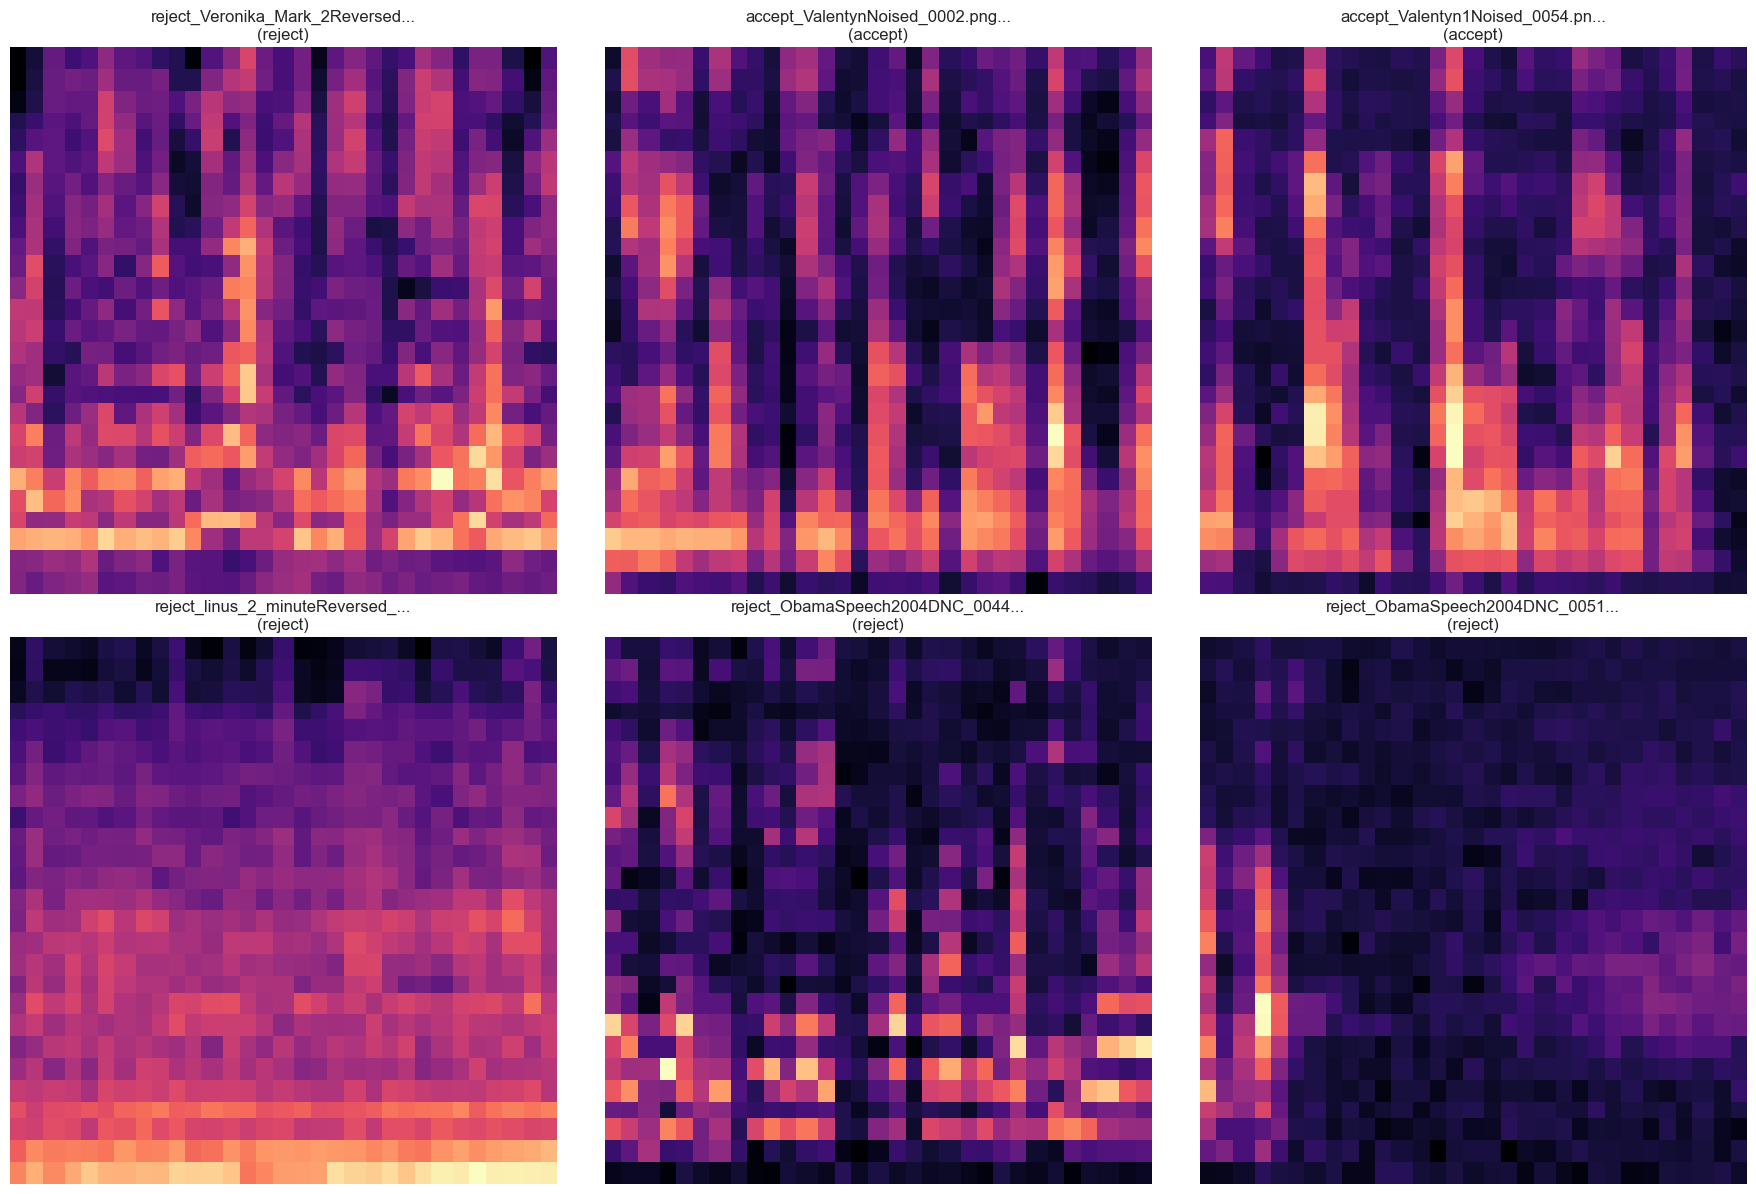

In [27]:
# Display sample spectrograms
if spectrogram_data:
    num_samples = min(6, len(spectrogram_data))
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.flatten()
    
    # Get samples from different labels if available
    labels_seen = set()
    samples_to_show = []
    for item in spectrogram_data:
        label = item.get('label', 'unknown')
        if label not in labels_seen or len(samples_to_show) < num_samples:
            samples_to_show.append(item)
            labels_seen.add(label)
        if len(samples_to_show) >= num_samples:
            break
    
    for idx, item in enumerate(samples_to_show):
        if idx < len(axes):
            axes[idx].imshow(item['image'], cmap='viridis' if len(item['image'].shape) == 2 else None)
            axes[idx].set_title(f"{item['file_name'][:30]}...\n({item.get('label', 'unknown')})")
            axes[idx].axis('off')
    
    # Hide unused subplots
    for idx in range(len(samples_to_show), len(axes)):
        axes[idx].axis('off')
    
    plt.tight_layout()
    plt.show()
else:
    print("No spectrogram data to display")
